<!--NOTEBOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="./figures/LogoOpenclassrooms.png">
<font size="4">
<p>
Cette étude a été réalisée dans le cadre du 5ème projet de ma formation Datascientist dispensée en MOOC par 
**<font color='blus'>Openclassrooms / écoles Centrale-Supélec</font>**.
</p>    

<p>
Ce notebook présente un modèle de ségmentation de clients d'un site d'achats en ligne. 
</p>
<p>
Ce modèle se base sur les données fournies par le site :
</p>
<p>
https://archive.ics.uci.edu/ml/datasets/Online+Retail
</p>
<p>
Ce notebook implémente les phases de l'analyse exploratoire de la façon suivante :
</p>
* l'acquisition des données traitées issues des notebook <font color='blue'>P5_2_RFM.ipynb</font>, <font color='blue'>P5_2_NLP.ipynb</font> et <font color='blue'>P5_2_timeFeature.ipynb</font>
* l'analyse exploiratoire des modeles de calcul   
* La recherche des paramètres optimaux pour les algorithmes :
    * de clustering
    * de prédiction par regression et méthodes ensemblistes.
* les mesures de tests des différents modèles
* Le test de prédiction de l'appartenance d'un client à un segment.


**Les résultats de cette analyse sont implémentés dans <font color='blue'>*P5_ModelBuilder*</font>**. 

Ce dernier composant permet construire un composant déployable réalisant des prédictions d'appartenance d'un client à un segment de marché.


In [1]:
import pandas as pd
import numpy as np
import time

import warnings
warnings.filterwarnings("ignore")


import p3_util
import p3_util_plot
import p5_util
import p5_util_plot

#--------------------------
# Process flow parameters
#--------------------------
is_reloaded = True

#---------------------------------------------------------------------------
# Outliers values issued from Total feature are removed or not from dataset.
is_total_no_outliers = False
#---------------------------------------------------------------------------

#---------------------------------------------------------------------------
# Encoded RFM features are clusterized separatly from other features.
#---------------------------------------------------------------------------
is_rfm_cluster = True


dict_month_name={1:'Jan',2:'Feb', 3:'Mar', 4:'Apr',5:'May', 6:'Jun', 7:'Jul',8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}


#### <font color='blue'>Restore into *df_invoice_line* dataframe the samples data-set</font>

In [2]:
import p5_util
if is_reloaded is True:
    df_invoice_line =  p5_util.p5_reload_data_sample(mode='random')
    print(df_invoice_line.shape)    

p5_util.object_load : fileName= ./data/df_invoice_line_sample_random.dump
(194907, 7)
(194907, 7)


In [3]:
nb_invoices = len(df_invoice_line['InvoiceNo'].unique())
print("\n*** Nombre de factures= "+str(nb_invoices))


*** Nombre de factures= 9330


In [4]:
nb_customers = len(df_invoice_line['CustomerID'].unique())
print("\n*** Nombre de clients= "+str(nb_customers))


*** Nombre de clients= 2124


In [5]:
import p5_util
df_invoice_line['Total'] = df_invoice_line.Quantity *  df_invoice_line.UnitPrice

df_invoice_line.query('Total>0')['InvoiceDate'].sort_values().apply(p5_util.p5_get_month_from_timestamp).unique()

array([12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int64)

# <font color='blus'>Restore into sepatated dataframes file issues from feature engineering</font>

####  Restore time based features

In [6]:
import p5_util
fileName = './data/df_customers_timeFeature_pca.dump'
df_customers_timeFeature = p5_util.object_load(fileName)

df_customers_timeFeature.shape

p5_util.object_load : fileName= ./data/df_customers_timeFeature_pca.dump


(2124, 30)

In [7]:
df_customers_timeFeature.sample(1)

,time_pca_0,time_pca_1,time_pca_2,time_pca_3,time_pca_4,time_pca_5,time_pca_6,time_pca_7,time_pca_8,time_pca_9,...,time_pca_20,time_pca_21,time_pca_22,time_pca_23,time_pca_24,time_pca_25,time_pca_26,time_pca_27,time_pca_28,time_pca_29
CustomerID,,,,,,,,,,,,,,,,,,,,,
15721,-0.133543,0.602126,-0.773169,0.608851,0.708689,0.055833,0.648765,-0.589512,0.415754,0.182254,...,-0.261529,-0.617216,0.835885,-0.75944,0.30402,0.559443,0.159961,-1.526474,-0.239355,-1.308737


####  Restore RFM features

In [8]:
import p5_util
fileName = './data/df_customers_RFM.dump'
df_customers_RFM = p5_util.object_load(fileName)

df_customers_RFM.shape

p5_util.object_load : fileName= ./data/df_customers_RFM.dump


(2124, 59)

####  Restore NLP features

In [9]:
import p5_util
fileName = './data/df_customers_pca_nlp.dump'
df_customers_NLP = p5_util.object_load(fileName)

df_customers_NLP.shape

p5_util.object_load : fileName= ./data/df_customers_pca_nlp.dump


(2124, 250)

In [10]:
df_customers_NLP.sample(1)

,nlp_pca_0,nlp_pca_1,nlp_pca_2,nlp_pca_3,nlp_pca_4,nlp_pca_5,nlp_pca_6,nlp_pca_7,nlp_pca_8,nlp_pca_9,...,nlp_pca_240,nlp_pca_241,nlp_pca_242,nlp_pca_243,nlp_pca_244,nlp_pca_245,nlp_pca_246,nlp_pca_247,nlp_pca_248,nlp_pca_249
CustomerID,,,,,,,,,,,,,,,,,,,,,
14522,-9.097464,1.388902,2.190396,0.646012,-0.053212,0.421801,0.249753,0.367363,0.564363,0.106059,...,0.078537,-0.247319,0.064818,0.12655,0.095741,0.193683,-0.018679,-0.000397,-0.268427,0.236552


#### Dataframes aggregation

In [11]:
import pandas as pd
df_customers = pd.DataFrame()

df_customers = pd.concat([df_customers,df_customers_RFM],  axis=1)
print(df_customers.shape)

df_customers = pd.concat([df_customers,df_customers_timeFeature], join='inner', axis=1)
print(df_customers.shape)

df_customers = pd.concat([df_customers,df_customers_NLP], join='inner', axis=1)
print(df_customers.shape)


(2124, 59)
(2124, 89)
(2124, 339)


#### Backup *df_customers* file 

In [12]:
import p5_util
fileName = './data/df_customers.dump'
p5_util.object_dump(df_customers, fileName)

# <font color='blus'> Clustering features</font>

#### Loading dumped file into *df_customers* dataframe

In [13]:
import p5_util
if is_reloaded is True:
    fileName = './data/df_customers.dump'
    df_customers = p5_util.object_load(fileName)
    print(df_customers.shape)

p5_util.object_load : fileName= ./data/df_customers.dump
(2124, 339)


## <font color='blue'> Kmeans Clustering / intra-inertia criteria</font>

In [14]:
import p5_util
cluster_start = 1
cluster_end = 10
dict_kmeans = p5_util.kmeans_scan_inter_inertia(df_customers, cluster_start, cluster_end)

Clustering : 1 clusters
Clustering : 2 clusters
Clustering : 3 clusters
Clustering : 4 clusters
Clustering : 5 clusters
Clustering : 6 clusters
Clustering : 7 clusters
Clustering : 8 clusters
Clustering : 9 clusters


#### Save of Kmeans clustering scan into a dumped file

In [15]:
import p5_util

fileName = './data/clustering_dict_kmeans_ALL.dump'
p5_util.object_dump(dict_kmeans, fileName)

#### Time features : Plot Clusters = F(intra-inertia)

p5_util.object_load : fileName= ./data/clustering_dict_kmeans_ALL.dump
Records into dict_kmeans= 9
1 9


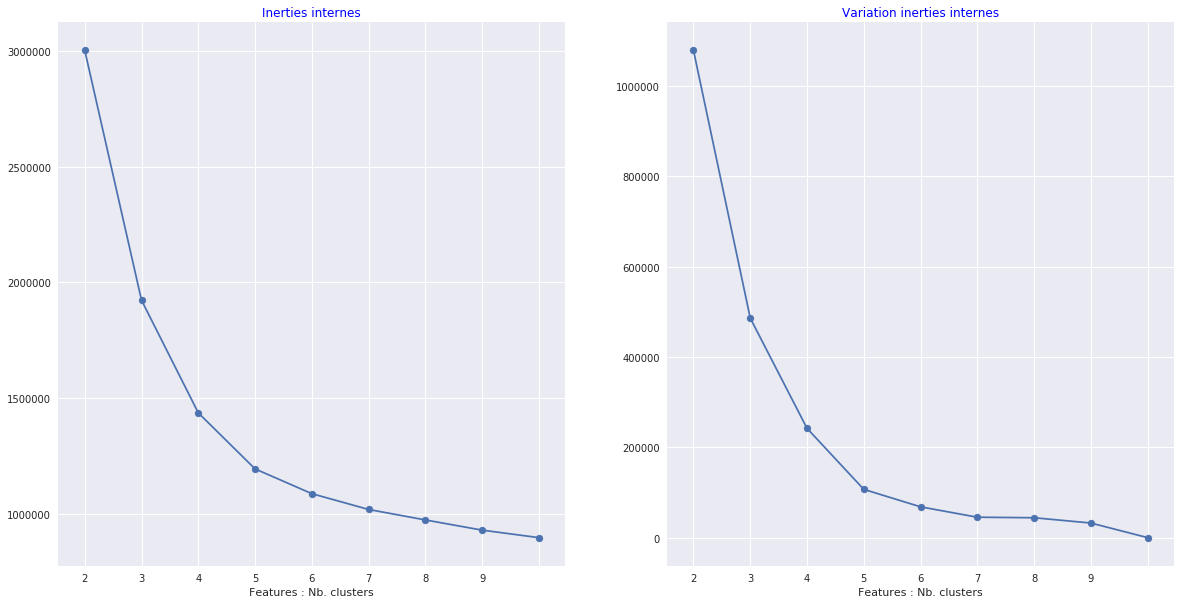

In [16]:
import p5_util_plot
import p5_util

if is_reloaded is True:
    fileName = './data/clustering_dict_kmeans_ALL.dump'
    dict_kmeans = p5_util.object_load(fileName)
    print("Records into dict_kmeans= "+str(len(dict_kmeans)))

x_label_0 = 'Features : Nb. clusters'
x_label_1 = 'Features : Nb. clusters'
cluster_start = list(dict_kmeans.keys())[0]
cluster_end = list(dict_kmeans.keys())[len(dict_kmeans)-1]
print(cluster_start, cluster_end)
p5_util_plot.plot_kmeans_interInertia(dict_kmeans, cluster_start, cluster_end\
                             ,[x_label_0, x_label_1]\
                             ,p_rows=1, p_cols=2, p_figsize=(20,10))

#### Clustering :  silhouette

In [17]:
import p5_util
import p5_util_plot

if True:
    fileName = './data/df_customers.dump'
    df_customers = p5_util.object_load(fileName)
    print("Features : "+str(df_customers.shape))
    
    #-------------------------------------------------------------------------------
    # Use kmeans dictionary to get numbers of clusters
    #-------------------------------------------------------------------------------
    fileName = './data/clustering_dict_kmeans_ALL.dump'
    dict_kmeans = p5_util.object_load(fileName)
    print("Clusters into dict_kmeans= "+str(len(dict_kmeans)))
    cluster_start = list(dict_kmeans.keys())[0]
    cluster_end = list(dict_kmeans.keys())[len(dict_kmeans)-1]
    print("Cluster start = "+str(cluster_start)+" Cluster end= "+str(cluster_end))
if 1 == cluster_start:
    cluster_start=2
dict_cluster_kmeans_silhouette = p5_util.kmeans_scan_silhouette(df_customers, cluster_start, cluster_end)

p5_util.object_load : fileName= ./data/df_customers.dump
Features : (2124, 339)
p5_util.object_load : fileName= ./data/clustering_dict_kmeans_ALL.dump
Clusters into dict_kmeans= 9
Cluster start = 1 Cluster end= 9
Cluster 2 done!
Cluster 3 done!
Cluster 4 done!
Cluster 5 done!
Cluster 6 done!
Cluster 7 done!
Cluster 8 done!


#### Backup silhouette clustering result

In [18]:
import p5_util
fileName = './data/dict_cluster_kmeans_silhouette_ALL.dump'
p5_util.object_dump(dict_cluster_kmeans_silhouette,fileName)

#### Plotting silhouette = F(nb clusters)

In [19]:
dict_kmeans

{1: KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=1, n_init=10, n_jobs=1, precompute_distances='auto',
     random_state=None, tol=0.0001, verbose=0),
 2: KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
     random_state=None, tol=0.0001, verbose=0),
 3: KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
     random_state=None, tol=0.0001, verbose=0),
 4: KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
     random_state=None, tol=0.0001, verbose=0),
 5: KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
     random_state=None, tol=0.0001, verbose=0),
 6: KMeans(algorithm='auto', copy_x=True, ini

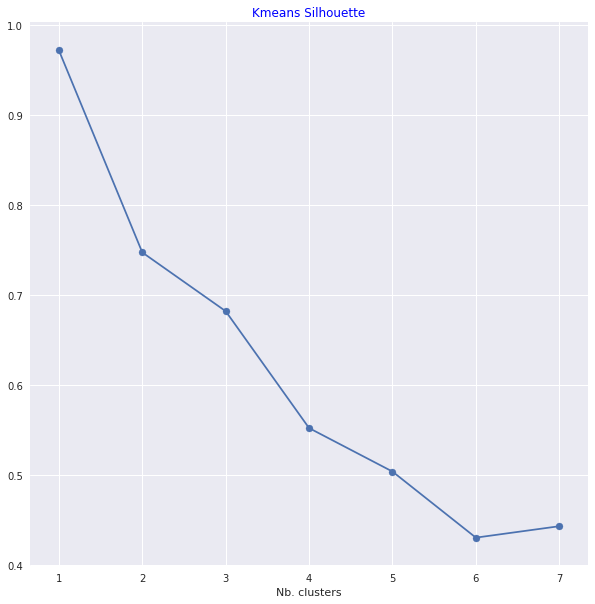

In [20]:
p_title='Kmeans Silhouette'
p5_util_plot.plot_kmeans_silhouette(dict_cluster_kmeans_silhouette, p_title, p_figsize=(10,10))

### <font color='blue'>Cluster model with best number of clusters</font>

In [21]:
n_cluster=6

In [22]:
cluster_kmean = dict_kmeans[n_cluster]
cluster_kmean
if 'cluster' in df_customers:
    del(df_customers['cluster'])
X = df_customers.values
preds_kmean = cluster_kmean.predict(X)

### <font color='blue'>Adding *cluster* issue from clustering into *df_customers*  as a new feature</font>

In [23]:
if 'cluster' in df_customers.columns:
    del(df_customers['cluster'])
df_customers.shape,preds_kmean.shape

((2124, 339), (2124,))

In [24]:
import p5_util

print(df_customers.shape)
df_customers = p5_util.df_add_cluster(df_customers, preds_kmean)
print(df_customers.shape)

(2124, 339)
(2124, 340)


### <font color='blue'>Showing elements count per cluster</font>

Clusters = [0 1 2 3 4 5]
Population cumulée par cluster = 2124
         Count
cluster       
0         1666
1            1
2           15
3            2
4           81
5          359


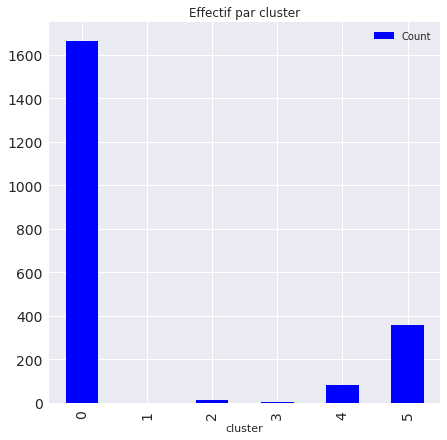

In [25]:
import p5_util_plot
p5_util_plot.plot_cluster_frequency(df_customers)

## <font color='blue'> DBSCAN clustering</font>

#### Distances distribution

In [26]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

if 'cluster' in df_customers.columns:
    del(df_customers['cluster'])
    
distances = pdist(df_customers.values, metric='euclidean')

print(np.min(distances), np.max(distances))



x_med = np.median(distances)
print("Distance median = "+str(x_med))
print("Nb elts de distances= "+str(len(distances)))
len(np.where(distances<x_med)[0])

raws = df_customers.shape[0]
print("Distance elts computing : n*(n+1)/2 - n = "+str(int((raws*(raws+1)/2)-raws)))

df_dist = pd.DataFrame(distances)

df_dist_quantiles = df_dist.quantile(q=[0.15, 0.25 ,0.5, 0.75, 0.95])

df_dist_quantiles.rename(columns={0:'Distance'},inplace=True)
df_dist_quantiles

0.47162559282705735 1048.613971668786
Distance median = 18.752372530810334
Nb elts de distances= 2254626
Distance elts computing : n*(n+1)/2 - n = 2254626


,Distance
0.15,8.536222
0.25,11.214456
0.50,18.752373
0.75,32.664145
0.95,80.108113


In [27]:
p_eps=31.0

#### Computing nb neighbours for 95% fo distances

In [28]:
import numpy as np

dist_matrix = squareform(distances)
print(dist_matrix.shape)
dict_ball_neighbour = dict()
for raw in range(0,dist_matrix.shape[0]):
    dict_ball_neighbour[raw] = len(np.where(dist_matrix[raw]<= p_eps)[0])

(2124, 2124)


In [29]:
ser_ball_neighbour = pd.Series(dict_ball_neighbour)
ser_neighbour_quantiles = ser_ball_neighbour.quantile(q=[0.15, 0.25 ,0.5, 0.75, 0.95, 1.0])
ser_neighbour_quantiles

0.15    1491.75
0.25    1796.75
0.50    1818.00
0.75    1826.00
0.95    1839.00
1.00    1855.00
dtype: float64

#### Apply of DBSCAN clustering

In [30]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=p_eps,min_samples=350, n_jobs=3)
if 'cluster' in df_customers.columns:
    del(df_customers['cluster'])
pred_dbscan =  dbscan.fit_predict(df_customers)

import numpy as np
np.unique(pred_dbscan)

array([-1,  0], dtype=int32)

#### DBSCAN : Plot Numbers per cluster

(2124, 339)
(2124, 340)
Clusters = [-1  0]
Population cumulée par cluster = 2124
         Count
cluster       
-1         203
 0        1921


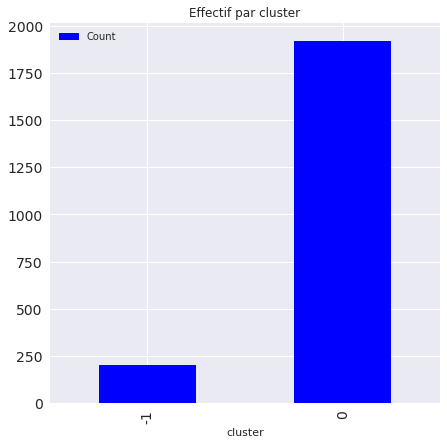

In [31]:
import p5_util
import p5_util_plot

print(df_customers.shape)
df_customers = p5_util.df_add_cluster(df_customers, pred_dbscan)
print(df_customers.shape)
p5_util_plot.plot_cluster_frequency(df_customers)

## <font color='blue'>GMM clustering</font>

#### Restore dataframe with reduced dimensions per customer and encoded values

In [32]:
import p5_util

if is_reloaded is True:
    fileName = './data/df_customers.dump'
    df_customers = p5_util.object_load(fileName)
    print(df_customers.shape)

if 'cluster' in df_customers.columns:
    del(df_customers['cluster'])
print(df_customers.shape)    

p5_util.object_load : fileName= ./data/df_customers.dump
(2124, 339)
(2124, 339)


#### Clustering to search for from a given range of clusters

In [33]:
cluster_start = 1
cluster_end = 11

#### GMM clustering evaluation : using BIC and AIC criterias
* AIC : provides a measure of statistical quality model. It measures loss of information (increase of entropy)  when multiple models are suggested, models with increaing complexity.
* BIC : comes from AIC

Goal : minimisation of both criterias

#### Cross-validation of GMM hyper-parameter : covariance type.

In [34]:
import p5_util
dict_hyper_parameter={'covariance_type':['diag','spherical','full']}
t_range_cluster = (cluster_start, cluster_end)
dict_list_gmm_model = p5_util.gmm_hyper_parameter_cv(df_customers, t_range_cluster ,dict_hyper_parameter)

Clustering from clusters range from : 1 --> 11
GMM Hyper-parameter type= covariance_type
Hyper parameter value : diag
Hyper parameter value : spherical
Hyper parameter value : full


#### Display AIC and BIC considering clusters number

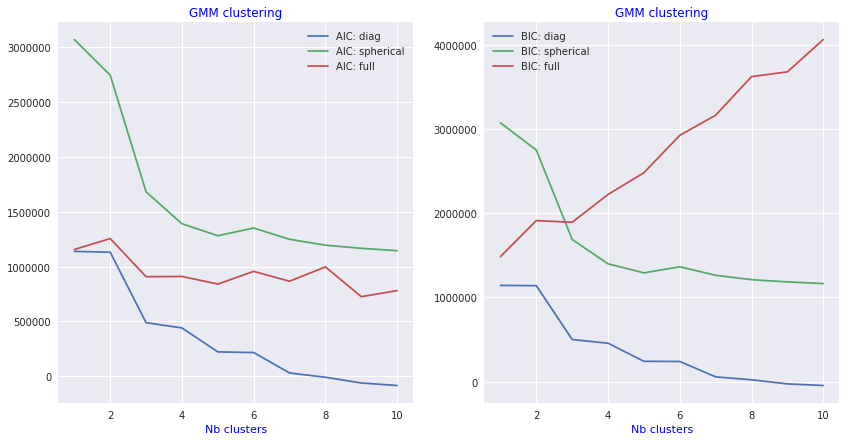

In [35]:
import p5_util_plot
p_figsize = (14,7)
t_range_cluster = (cluster_start, cluster_end)
p_title = 'GMM clustering'
p5_util_plot.gmm_models_plot_AIC_BIC(df_customers, dict_list_gmm_model, t_range_cluster, p_figsize, p_title)

<font color='red'>Loss of information is optimized for clusters number = 4</font>

#### GMM models evaluation:  computation of silhouette score

In [36]:
import p5_util
dict_dict_silhouette_score = p5_util.gmm_silhouette_compute(df_customers, dict_list_gmm_model)

GMM Silhouette score: Hyper-parameter = diag
GMM Silhouette score: Cluster= 2
GMM Silhouette score: Cluster= 3
GMM Silhouette score: Cluster= 4
GMM Silhouette score: Cluster= 5
GMM Silhouette score: Cluster= 6
GMM Silhouette score: Cluster= 7
GMM Silhouette score: Cluster= 8
GMM Silhouette score: Cluster= 9
GMM Silhouette score: Cluster= 10

GMM Silhouette score: Hyper-parameter = spherical
GMM Silhouette score: Cluster= 2
GMM Silhouette score: Cluster= 3
GMM Silhouette score: Cluster= 4
GMM Silhouette score: Cluster= 5
GMM Silhouette score: Cluster= 6
GMM Silhouette score: Cluster= 7
GMM Silhouette score: Cluster= 8
GMM Silhouette score: Cluster= 9
GMM Silhouette score: Cluster= 10

GMM Silhouette score: Hyper-parameter = full
GMM Silhouette score: Cluster= 2
GMM Silhouette score: Cluster= 3
GMM Silhouette score: Cluster= 4
GMM Silhouette score: Cluster= 5
GMM Silhouette score: Cluster= 6
GMM Silhouette score: Cluster= 7
GMM Silhouette score: Cluster= 8
GMM Silhouette score: Cluster= 

#### Plot silhouette score for any type of covariance and for any type of GMM model

* For each covariance type (spherical, diag and full), GMM models ranking from *cluster_start* to *cluster_end* have been built

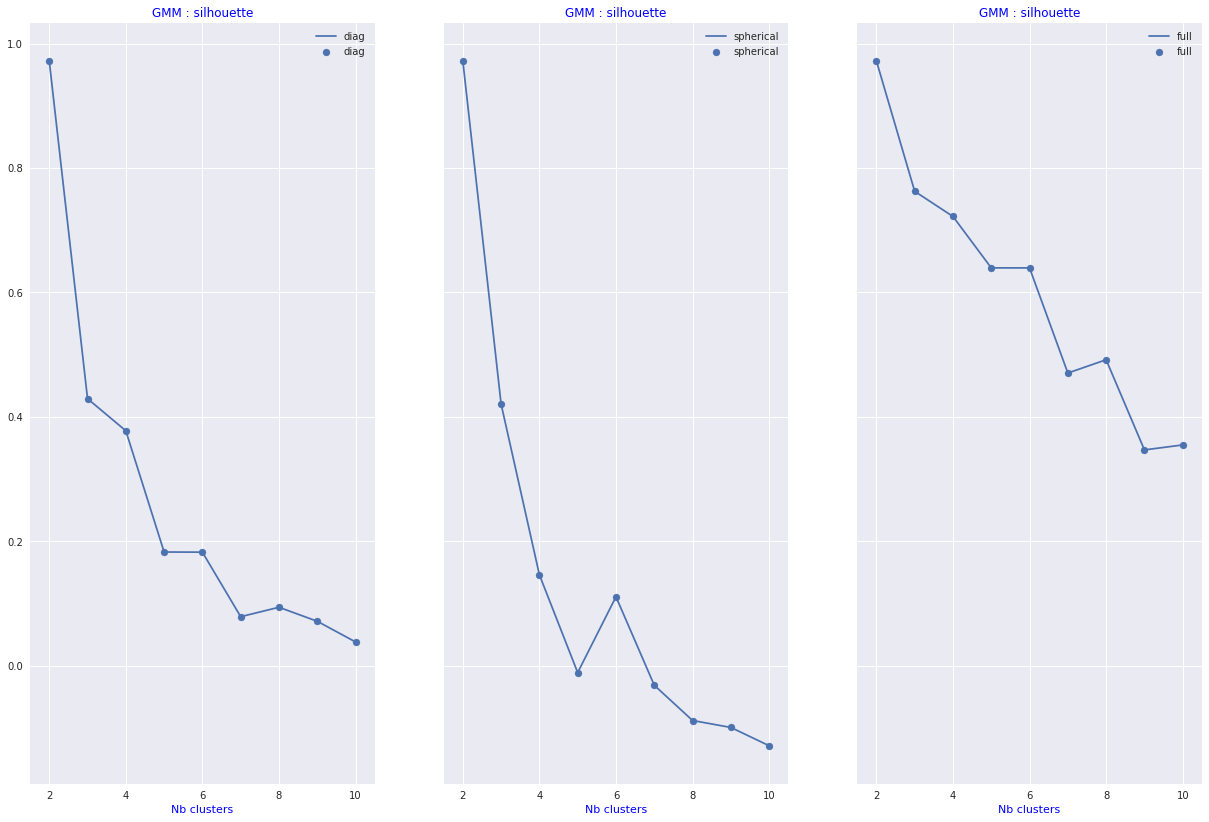

In [37]:
import p5_util_plot
p_figsize=(21,14)
areas_raws =1
areas_colums =3
p_title = "GMM : silhouette"
p5_util_plot.gmm_models_plot_silhouette(df_customers, dict_dict_silhouette_score\
, p_figsize, p_title, areas_raws, areas_colums)

* <font color='red'>GMM : Silhouette coef. decreases with number of clusters, whatever hyper-parameters values</font>
* <font color='red'>GMM : hyper-parameters with ``diag`` value has the best performance</font>


#### Selection of best clusters count with optimum covariance type

In [38]:
p_covariance_type = 'diag'
n_cluster = 6
list_gmm_model = dict_list_gmm_model[p_covariance_type]
for gmm_model in list_gmm_model:
    if n_cluster == gmm_model.n_components:
        break
gmm_model

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
        means_init=None, n_components=6, n_init=1, precisions_init=None,
        random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

#### Display number of elements in each cluster due to ``GMM``

(2124, 339)
(2124, 340)
Clusters = [0 1 2 3 4 5]
Population cumulée par cluster = 2124
         Count
cluster       
0         1283
1            1
2          303
3            1
4          535
5            1


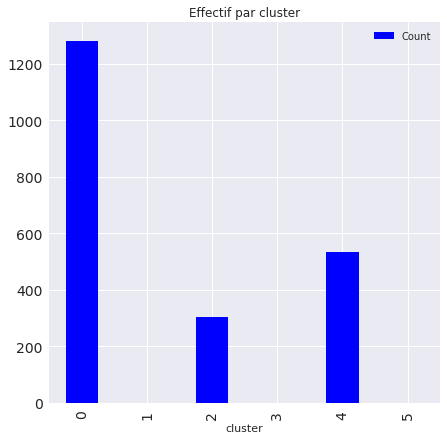

In [39]:
import p5_util
import p5_util_plot
if 'cluster' in df_customers.columns:
    del(df_customers['cluster'])

if 'CustomerID' in df_customers.columns:
    del(df_customers['CustomerID'])
    

    
pred_gmm = gmm_model.predict(df_customers.values)
print(df_customers.shape)
df_customers = p5_util.df_add_cluster(df_customers, pred_gmm)
print(df_customers.shape)
p5_util_plot.plot_cluster_frequency(df_customers)

Backup of ``df_customers`` dataframe with added clusters

In [40]:
import p5_util
p5_util.object_dump(df_customers,'./data/df_customers_cluster.dump')
print(df_customers.shape)
print('cluster' in df_customers.columns)

(2124, 340)
True


#### Cluster list selection

In [41]:
list_cluster = [0,2,4]
list_cluster

[0, 2, 4]

# <font color='blus'>Using a supervised M.L. algorithm for market segments prediction</font>

In [42]:
import p5_util
df_customers = p5_util.object_load('./data/df_customers_cluster.dump')
print(df_customers.shape)
print('cluster' in df_customers.columns)

p5_util.object_load : fileName= ./data/df_customers_cluster.dump
(2124, 340)
True


Target vector for supervised ML algorithm is extracted from column ``cluster`` in ``df_customers`` dataframe.

Data belonging to clusters from ``list_cluster``  are extraced.

In [43]:
import p5_util
df_customers = p5_util.df_customers_cluster_filter(df_customers, list_cluster)

(2124, 340)
(2121, 340)


Dataframe ``df_customers`` is filtered considering ``list_cluster``

In [45]:
import numpy as np

list_all_cluster = np.unique(df_customers.cluster.values)

print(df_customers.shape)

for cluster in list_all_cluster:
    if cluster not in list_cluster:
        df_customers = df_customers[df_customers.cluster != cluster ]

print(df_customers.shape)
y_sample = df_customers.cluster.values
print(y_sample.shape, type(y_sample))

(2121, 340)
(2121, 340)
(2121,) <class 'numpy.ndarray'>


In [46]:
np.unique(y_sample)

array([0, 2, 4])

Dataframe of customers values is used to split data between train and test

In [49]:
from sklearn.model_selection import train_test_split

list_col_drop = ['cluster']
list_col_keep =[col for col in df_customers.columns if col not in list_col_drop]
is_nan_in_arr = np.isnan(df_customers[list_col_keep].values)
print("Nan values : "+str(True in is_nan_in_arr))


X_train, X_test, y_train, y_test = train_test_split(df_customers[list_col_keep].values, y_sample, test_size=0.6)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)


Nan values : False
(848, 339) (1273, 339)
(848,) (1273,)


## <font color='blue'>Using *RandomForests* for observations classification into segments</font>

### <font color='blue'>RandomForests : searching for bests parameters </font>

In [53]:
from sklearn.ensemble import RandomForestClassifier

import p5_util

dict_score_global = dict()
list_estimators = list(np.arange(10,90,10))
list_estimators = list(np.arange(2,21,1))
#list_estimators = [10,20]
nb_repetition = 10
total_score_global = 0.0
nb_segments = len(np.unique(y_sample))

#-------------------------------------------------------------
# dict_score_forest_mean is initialized
#-------------------------------------------------------------
dict_score_forest_mean = dict()

for  nb_estimators in list_estimators:
    print("\n---------------- Random forest classifier : "+str(nb_estimators)+" forests / "+str(nb_repetition)+" repetition(s) ---------------------")
    dict_score_segment_mean = dict()
    #-----------------------------------------------------------------------
    # Each cluster is identified as a market segment
    #-----------------------------------------------------------------------
    for segment in list_cluster:
        dict_score_segment_mean[segment] = 0.0
        
    for repeat in range(0,nb_repetition):
        rfc = RandomForestClassifier(n_estimators=nb_estimators)
        rfc_model = rfc.fit(X_train, y_train)
        y_pred = rfc_model.predict(X_test)

        #------------------------------------------------------
        # dict_score_segment contains accuracy for any segment.
        #------------------------------------------------------
        score_global, dict_score_segment = p5_util.compute_precision_per_segment(y_test, y_pred,list_cluster)  
        
        #-------------------------------------------------------
        # Accuracy per segment and per repetition is accumulated 
        #-------------------------------------------------------
        for segment, accuracy in dict_score_segment.items():
            dict_score_segment_mean[segment] += accuracy
            
        dict_score_global[nb_estimators] = score_global
        total_score_global += score_global
    #----------------------------------------------------------
    # At end of repetitions, mean accuracy per segment is computed
    #----------------------------------------------------------
    total_score_global /= nb_repetition
    for segment, accuracy in dict_score_segment_mean.items():
        dict_score_segment_mean[segment] /= nb_repetition
    #----------------------------------------------------------
    # Mean accuracy for a forest is stored
    #----------------------------------------------------------
    dict_score_forest_mean[nb_estimators] = (dict_score_segment_mean,total_score_global)
    total_score_global = 0.0
    #print("\nGlobal segment precision: {0:1.2F}".format(total_score_global))
    #print("----------------------------------------------------------------------------------------------\n")



---------------- Random forest classifier : 2 forests / 10 repetition(s) ---------------------

---------------- Random forest classifier : 3 forests / 10 repetition(s) ---------------------

---------------- Random forest classifier : 4 forests / 10 repetition(s) ---------------------

---------------- Random forest classifier : 5 forests / 10 repetition(s) ---------------------

---------------- Random forest classifier : 6 forests / 10 repetition(s) ---------------------

---------------- Random forest classifier : 7 forests / 10 repetition(s) ---------------------

---------------- Random forest classifier : 8 forests / 10 repetition(s) ---------------------

---------------- Random forest classifier : 9 forests / 10 repetition(s) ---------------------

---------------- Random forest classifier : 10 forests / 10 repetition(s) ---------------------

---------------- Random forest classifier : 11 forests / 10 repetition(s) ---------------------

---------------- Random forest classi

### <font color='blue'>Display accuracy per segment and global accuracy</font>

In [54]:
import numpy as np
list_forests = list()
list_global_accuracy = list()
list_segment_accuracy = list()

for forest, (dict_segment_accuracy, global_accuracy) in dict_score_forest_mean.items():
    
    print("\n----------------- Forests : "+str(forest)+" / Repetitions : "+str(nb_repetition)+" -----------------")
    print("Global accuracy = {}".format(np.format_float_positional(global_accuracy, precision=2)))
    list_forests.append(forest)
    list_global_accuracy.append(global_accuracy)
    for segment, accuracy in dict_segment_accuracy.items():
        if segment in list_cluster:
            print("Segment : {0} / Mean accuracy for {1} repetitions : {2:0.2F}".format(segment,nb_repetition,accuracy))
    print("-------------------------------------------------------------------------\n")


----------------- Forests : 2 / Repetitions : 10 -----------------
Global accuracy = 0.69
Segment : 0 / Mean accuracy for 10 repetitions : 0.74
Segment : 2 / Mean accuracy for 10 repetitions : 0.54
Segment : 4 / Mean accuracy for 10 repetitions : 0.54
-------------------------------------------------------------------------


----------------- Forests : 3 / Repetitions : 10 -----------------
Global accuracy = 0.72
Segment : 0 / Mean accuracy for 10 repetitions : 0.79
Segment : 2 / Mean accuracy for 10 repetitions : 0.65
Segment : 4 / Mean accuracy for 10 repetitions : 0.53
-------------------------------------------------------------------------


----------------- Forests : 4 / Repetitions : 10 -----------------
Global accuracy = 0.73
Segment : 0 / Mean accuracy for 10 repetitions : 0.81
Segment : 2 / Mean accuracy for 10 repetitions : 0.61
Segment : 4 / Mean accuracy for 10 repetitions : 0.56
-------------------------------------------------------------------------


---------------

### <font color='blue'>Plot accuracy per segment and global accuracy</font>

[]

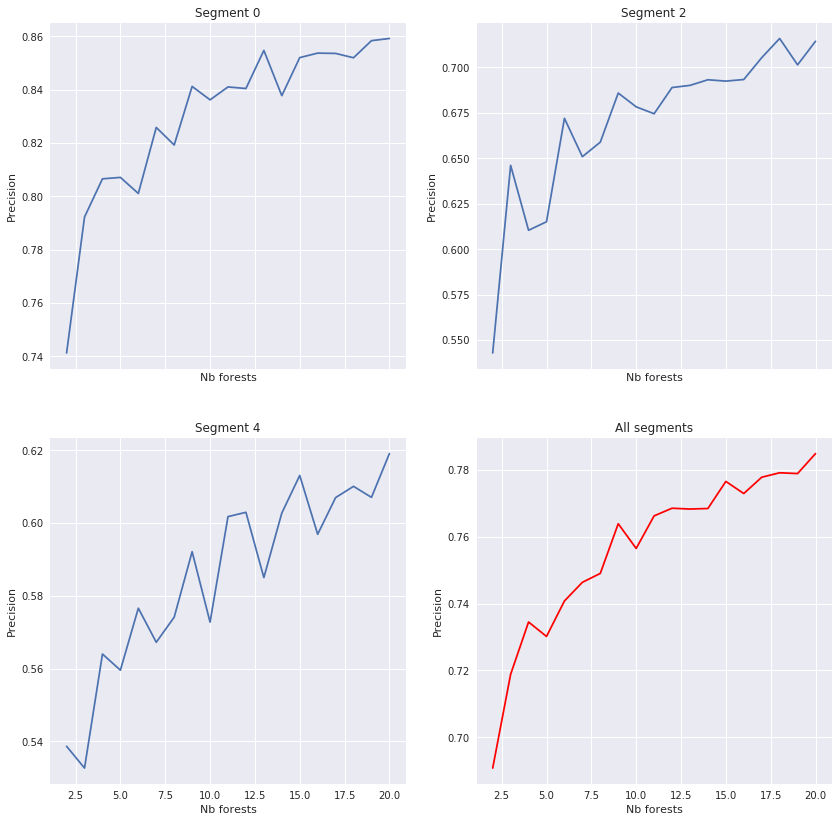

In [55]:
import matplotlib.pyplot as plt

f, axes = plt.subplots(2, 2, figsize=(14, 14), sharex=True)

dict_forest_segment_accuracy = dict()

for segment in list_cluster:
    list_forest_segment_accuracy = list()
    for forest, (dict_segment_accuracy, global_accuracy) in dict_score_forest_mean.items():
        segment_accuracy = dict_segment_accuracy[segment]
        list_forest_segment_accuracy.append(segment_accuracy)
    dict_forest_segment_accuracy[segment] = list_forest_segment_accuracy
    list_forest_segment_accuracy = None         
        
#for segment, list_forest_segment_accuracy in dict_forest_segment_accuracy.items():
title = 'Segment 0'
if True:
    row = 0
    col = 0
    axes[row,col].plot(list_forests, dict_forest_segment_accuracy[0])
    axes[row,col].set_title(title)
    axes[row,col].set_xlabel('Nb forests')
    axes[row,col].set_ylabel('Precision')

if False:
    row = 0
    col = 1
    title = 'Segment 1'
    axes[row,col].plot(list_forests, dict_forest_segment_accuracy[1])
    axes[row,col].set_title(title)
    axes[row,col].set_xlabel('Nb forests')
    axes[row,col].set_ylabel('Precision')

if True:
    row = 0
    col = 1
    title = 'Segment 2'
    axes[row,col].plot(list_forests, dict_forest_segment_accuracy[2])
    axes[row,col].set_title(title)
    axes[row,col].set_xlabel('Nb forests')
    axes[row,col].set_ylabel('Precision')

if False:
    row = 0
    col = 1
    title = 'Segment 3'
    axes[row,col].plot(list_forests, dict_forest_segment_accuracy[3])
    axes[row,col].set_title(title)
    axes[row,col].set_xlabel('Nb forests')
    axes[row,col].set_ylabel('Precision')

if True:
    row = 1
    col = 0
    title = 'Segment 4'
    axes[row,col].plot(list_forests, dict_forest_segment_accuracy[4])
    axes[row,col].set_title(title)
    axes[row,col].set_xlabel('Nb forests')
    axes[row,col].set_ylabel('Precision')

row = 1
col = 1
title = 'All segments'
axes[row,col].plot(list_forests, list_global_accuracy, color='red')
axes[row,col].set_title(title)
axes[row,col].set_xlabel('Nb forests')
axes[row,col].set_ylabel('Precision')

plt.plot()

<font color='red'>Nombre optimal d'estimateurs :  18</font>

### <font color='blue'>Random Forest :features importancy </font>

In [142]:
import p3_util_plot

from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score

p_threshold = 0.001
select = SelectFromModel(rfc_best_model, prefit=True, threshold=p_threshold)
print(X_train.shape)
X_train2 = select.transform(X_train)
X_test2 = select.transform(X_test)
print(X_train2.shape)
rfc_reduced = RandomForestClassifier(n_estimators=19).fit(X_train2, y_train)


pred = rfc_reduced.predict(X_test2)
#score = metrics.accuracy_score(y_test, y_pred)
p3_util_plot.printmd("Random forest precision with importance threshold= "+str(p_threshold)+" : "+str(accuracy_score(y_test, pred)))

(848, 339)
(848, 232)


<p><font color='green'>**Random forest precision with importance threshold= 0.001 : 0.8012568735271013**</font></p>

For 30% feaures less, decrease of accuracy is sensible. It is decided to keep model with 339 features.

### <font color='blue'>Random Forest : confusion matrix for each of the clusters</font>

Optimal RF model trained with ``(X_train, y_train)`` is used.

In [144]:
nb_estimators=19

In [145]:
nb_estimators
rfc = RandomForestClassifier(n_estimators=nb_estimators)
rfc_best_model = rfc.fit(X_train, y_train)

Get customerID from ``y_test`` for each one the clusters

In [146]:
import numpy as np
for cluster in list_cluster:
    
    y_true_index = np.where(y_sample==cluster)[0]
    y_true = y_sample[y_true_index]
    print(cluster, y_true.shape)
    #print(y_true.shape)
y_true.shape

0 (1283,)
2 (303,)
4 (535,)


(535,)

In [147]:
from sklearn import metrics
y_pred = rfc_best_model.predict(X_test)
metrics.confusion_matrix(y_test, y_pred, labels=[0,2,4])

array([[702,   7,  59],
       [ 10, 112,  54],
       [ 96,  45, 188]], dtype=int64)

In [148]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

#---------------------------------------------------------------------------------
# Following function is extraced from URl :
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
#---------------------------------------------------------------------------------
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greys):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, color='blue', fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', color='blue')
    plt.xlabel('Predicted label', color='blue')

Confusion matrix, without normalization
[[702   7  59]
 [ 10 112  54]
 [ 96  45 188]]


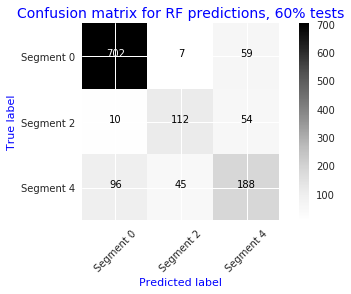

In [149]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred, labels=[0,2,4])
np.set_printoptions(precision=2)
class_names=['Segment 0','Segment 2','Segment 4']

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,  title='Confusion matrix for RF predictions, 60% tests')

# Plot normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
#                      title='Normalized confusion matrix')

plt.show()

In [150]:
dict_crit_perf= dict()
#---------------------------------------
# Segment 0
#---------------------------------------
segment = 0
FP = 0+68
FN = 2+108
TP = 725
TN = y_test.shape[0]-(FP + FN + TP)
dict_segment = dict()
dict_segment['FP'] = FP
dict_segment['FN'] = FN
dict_segment['TP'] = TP
dict_segment['TN'] = TN

dict_crit_perf[0] = dict_segment

#---------------------------------------
# Segment 2
#---------------------------------------
segment = 2
FP = 2 + 27
FN = 4 + 0
TP = 107
TN = y_test.shape[0]-(FP + FN + TP)
dict_segment = dict()
dict_segment['FP'] = FP
dict_segment['FN'] = FN
dict_segment['TP'] = TP
dict_segment['TN'] = TN

dict_crit_perf[segment] = dict_segment

#---------------------------------------
# Segment 4
#---------------------------------------
segment = 4
FP = 108+4
FN = 68+27
TP = 232
TN = y_test.shape[0]-(FP + FN + TP)
dict_segment = dict()
dict_segment['FP'] = FP
dict_segment['FN'] = FN
dict_segment['TP'] = TP
dict_segment['TN'] = TN

dict_crit_perf[segment] = dict_segment

for segment in dict_crit_perf.keys():
    dict_segment = dict_crit_perf[segment]
    
    recall = dict_segment['TP']/(dict_segment['TP']+dict_segment['FN'])
    precision = dict_segment['TP']/(dict_segment['TP']+dict_segment['FP'])
    fmesure = (2*dict_segment['TP'])/(2*dict_segment['TP']+dict_segment['FP']+dict_segment['FN'])
    specificity = dict_segment['TN']/(dict_segment['FP']+dict_segment['TN'])
    
    print("Segment : "+str(segment)+" : Recall= "+str(recall)+" Precision= "+str(precision)+" F-mesure= "+str(fmesure)+" Specifity= "+str(specificity)+"\n")

Segment : 0 : Recall= 0.8682634730538922 Precision= 0.914249684741488 F-mesure= 0.8906633906633906 Specifity= 0.8447488584474886
Segment : 2 : Recall= 0.963963963963964 Precision= 0.7867647058823529 F-mesure= 0.8663967611336032 Specifity= 0.9750430292598967
Segment : 4 : Recall= 0.709480122324159 Precision= 0.6744186046511628 F-mesure= 0.6915052160953801 Specifity= 0.8816067653276956


## <font color='blue'>Using SVC for observations classification into segments</font>

In [62]:
import p5_util
import sklearn

dict_svm_model = dict()
list_svm_kernel = ['rbf','linear','poly','sigmoid']
for p_kernel in list_svm_kernel:
    svm_model = sklearn.svm.SVC(kernel=p_kernel)
    svm_model.fit(X_train, y_train)
    dict_svm_model[p_kernel] = svm_model

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)




#------------------------------------------------------
# dict_score_segment contains accuracy for any segment.
#------------------------------------------------------
dict_score_global_svm = dict()
dict_dict_score_segment_svm = dict()
nb_segments = len(np.unique(y_sample))

for p_kernel, svm_model in dict_svm_model.items():    
    y_pred = svm_model.predict(X_test)
    score_global_svm, dict_score_segment_svm \
    = p5_util.compute_precision_per_segment(y_test, y_pred,list_cluster)  
    dict_score_global_svm[p_kernel] = score_global_svm
    dict_dict_score_segment_svm[p_kernel] = dict_score_segment_svm
    print("\nSVC : kernel= "+str(p_kernel)+"\nAccuracy / segment : {} \nGlobal accuracy : {}".format(dict_score_segment_svm, score_global_svm))

(848, 339) (1273, 339)
(848,) (1273,)

SVC : kernel= rbf
Accuracy / segment : {0: 0.8242630385487528, 2: 0.6894736842105263, 4: 0.6169154228855721} 
Global accuracy : 0.7714061272584446

SVC : kernel= linear
Accuracy / segment : {0: 0.875, 2: 0.7428571428571429, 4: 0.7119741100323624} 
Global accuracy : 0.8208955223880597

SVC : kernel= poly
Accuracy / segment : {0: 0.697992700729927, 2: 0.8, 4: 0.5161290322580645} 
Global accuracy : 0.6983503534956795

SVC : kernel= sigmoid
Accuracy / segment : {0: 0.8181818181818182, 2: 0.4365482233502538, 4: 0.48792270531400966} 
Global accuracy : 0.7054202670856246


### <font color='blue'>SVC : confusion matrix for each of the clusters</font>

Confusion matrix, without normalization
[[721   3  44]
 [ 27 104  45]
 [ 76  33 220]]


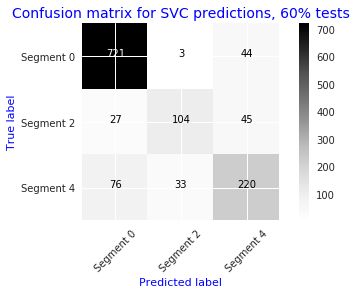

In [63]:
svm_model = dict_svm_model['linear']
y_pred = svm_model.predict(X_test)
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred, labels=[0,2,4])
np.set_printoptions(precision=2)
class_names=['Segment 0','Segment 2','Segment 4']

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,  title='Confusion matrix for SVC predictions, 60% tests')

# Plot normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
#                      title='Normalized confusion matrix')

plt.show()

In [64]:
cnf_matrix.ravel()
dict_crit_perf= dict()
#---------------------------------------
# Segment 0
#---------------------------------------
segment = 0
FP = 1+63
FN = 19+62
TP = 729
TN = y_test.shape[0]-(FP + FN + TP)
dict_segment = dict()
dict_segment['FP'] = FP
dict_segment['FN'] = FN
dict_segment['TP'] = TP
dict_segment['TN'] = TN

dict_crit_perf[0] = dict_segment

#---------------------------------------
# Segment 2
#---------------------------------------
segment = 2
FP = 19 + 63
FN = 24 + 1
TP = 54
TN = y_test.shape[0]-(FP + FN + TP)
dict_segment = dict()
dict_segment['FP'] = FP
dict_segment['FN'] = FN
dict_segment['TP'] = TP
dict_segment['TN'] = TN

dict_crit_perf[segment] = dict_segment

#---------------------------------------
# Segment 4
#---------------------------------------
segment = 4
FP = 63+63
FN = 62+24
TP = 258
TN = y_test.shape[0]-(FP + FN + TP)
dict_segment = dict()
dict_segment['FP'] = FP
dict_segment['FN'] = FN
dict_segment['TP'] = TP
dict_segment['TN'] = TN

dict_crit_perf[segment] = dict_segment

for segment in dict_crit_perf.keys():
    dict_segment = dict_crit_perf[segment]
    
    recall = dict_segment['TP']/(dict_segment['TP']+dict_segment['FN'])
    precision = dict_segment['TP']/(dict_segment['TP']+dict_segment['FP'])
    fmesure = (2*dict_segment['TP'])/(2*dict_segment['TP']+dict_segment['FP']+dict_segment['FN'])
    specificity = dict_segment['TN']/(dict_segment['FP']+dict_segment['TN'])
    
    print("Segment : "+str(segment)+" : Recall= "+str(recall)+" Precision= "+str(precision)+" F-mesure= "+str(fmesure)+" Specifity= "+str(specificity))

Segment : 0 : Recall= 0.9 Precision= 0.9192938209331651 F-mesure= 0.9095446038677479 Specifity= 0.8617710583153347
Segment : 2 : Recall= 0.6835443037974683 Precision= 0.39705882352941174 F-mesure= 0.5023255813953489 Specifity= 0.931323283082077
Segment : 4 : Recall= 0.75 Precision= 0.671875 F-mesure= 0.7087912087912088 Specifity= 0.8643702906350915


# <font color='blus'>Clusters analysis</font>

#### <font color='blue'>Restore ``df_invoice_line`` and ``df_customers_cluster`` dataframes</font>

In [152]:
import p5_util
is_reloaded = True
if is_reloaded is True:
    df_invoice_line = p5_util.p5_reload_data_sample()
    print(df_invoice_line.shape)  
n_cluster=6

import p5_util
if is_reloaded is True:
    
    df_customers = p5_util.object_load('./data/df_customers_cluster.dump')
    print(df_customers.shape)
    print("Cluster into df_customers : "+str('cluster'in df_customers.columns))

p5_util.object_load : fileName= ./data/df_invoice_line_sample_random.dump
(194907, 7)
(194907, 7)
p5_util.object_load : fileName= ./data/df_customers_cluster.dump
(2124, 340)
Cluster into df_customers : True


In [153]:
df_invoice_line.CustomerID.unique().shape

(2124,)

In [154]:
import p3_util_plot
p3_util_plot.printmd("Cluster count : "+str(df_customers.cluster.unique().shape[0]))

<p><font color='green'>**Cluster count : 6**</font></p>

### POD activity per cluster

``POD`` feature is added into ``df_invoice_line`` dataframe column

In [155]:
import p5_util
if 'POD' not in df_invoice_line.columns:
    df_invoice_line['POD'] = df_invoice_line['InvoiceDate'].apply(p5_util.p5_get_pod_from_timestamp)
df_invoice_line.sample(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,POD
155279,559138,21523,DOORMAT FANCY FONT HOME SWEET HOME,1,2011-07-06 13:35:00,7.95,16919,1


``cluster`` column is addad to ``df_invoice_line``

In [156]:
if 'CustomerID' not in df_customers.columns:
    print('cluster' in df_customers.columns)
    df_customers.reset_index(inplace=True)


if 'cluster' in df_invoice_line.columns:
    del(df_invoice_line['cluster'])

df_invoice_line = pd.merge(df_invoice_line, df_customers[['CustomerID','cluster']], on='CustomerID')
df_invoice_line.sample()

True


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,POD,cluster
156070,571294,23265,SET OF 3 WOODEN TREE DECORATIONS,2,2011-10-16 16:09:00,1.25,16987,1,2


Clusters are filetered considering ``list_cluster``

In [157]:
print(list_cluster)
df_invoice_line.cluster.unique()

[0, 2, 4]


array([2, 4, 0, 3, 1, 5], dtype=int64)

In [158]:
for cluster in list_cluster:
    print(df_invoice_line[df_invoice_line.cluster==cluster].shape)

(41212, 9)
(86707, 9)
(52226, 9)


In [159]:
import p5_util
df_invoice_line = p5_util.df_cluster_filter(df_invoice_line, list_cluster)
print("Nb customers : " +str(df_invoice_line.CustomerID.unique().shape[0]))
print("list of filtered clusters : " +str(list_cluster))

Nb customers : 2121
list of filtered clusters : [0, 2, 4]


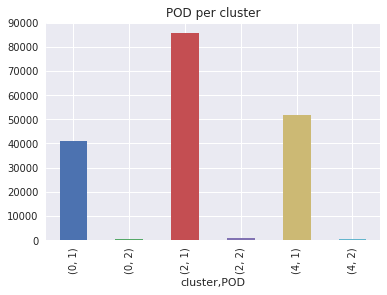

In [160]:
#df_invoice_line.groupby(['cluster','POD'])['POD'].size().plot(kind='bar',stacked=True)
z_ = df_invoice_line.groupby(['cluster','POD'])['POD'].size().plot(kind='bar',title='POD per cluster')

### Month activity per cluster

In [161]:
import p5_util
if is_reloaded is True:
    fileName = './data/df_customers_cluster.dump'
    df_customers = p5_util.object_load(fileName)
    print(df_customers.shape)

p5_util.object_load : fileName= ./data/df_customers_cluster.dump
(2124, 340)


``Month`` feature is added into ``df_invoice_line`` dataframe column

In [162]:
import p5_util
if 'Month' not in df_invoice_line.columns:
    df_invoice_line['Month'] = df_invoice_line['InvoiceDate'].apply(p5_util.p5_get_month_from_timestamp)
df_invoice_line.sample(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,POD,cluster,Month
56644,537772,22951,60 CAKE CASES DOLLY GIRL DESIGN,1,2010-12-08 12:35:00,0.55,18043,1,0,12


``cluster`` column is added to ``df_invoice_line``

In [163]:
'cluster' in df_customers.columns

True

In [164]:
if 'CustomerID' not in df_customers.columns:
    print('cluster' in df_customers.columns)
    df_customers.reset_index(inplace=True)

if 'cluster' in df_customers.columns:
    del(df_invoice_line['cluster'])

df_invoice_line = pd.merge(df_invoice_line, df_customers[['CustomerID','cluster']], on='CustomerID')
df_invoice_line.sample()

True


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,POD,Month,cluster
127704,574476,23333,IVORY WICKER HEART MEDIUM,2,2011-11-04 12:20:00,1.25,17203,1,11,2


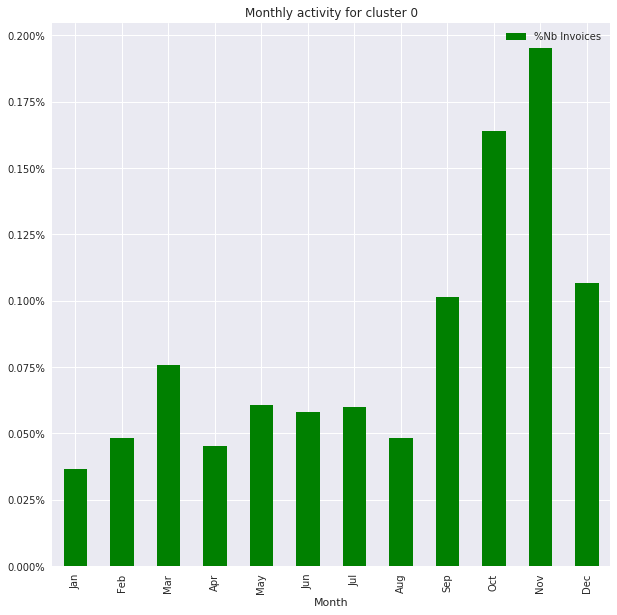

In [165]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

feature = 'Month'
cluster = 0
df = df_invoice_line[df_invoice_line.cluster==cluster].groupby([feature]).agg({'InvoiceNo': lambda x:len(x)})
df = df.apply(lambda x: x/sum(x))
df.rename(columns={'InvoiceNo':'%Nb Invoices'}, inplace=True)
dict_month_name={1:'Jan',2:'Feb', 3:'Mar', 4:'Apr',5:'May', 6:'Jun', 7:'Jul',8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
df.rename(dict_month_name,axis='index', inplace=True)

z_ = plt.figure(figsize=(10,10))
axes = plt.gca()
axes.set_xlabel('Months')
axes.yaxis.set_major_formatter(mtick.PercentFormatter())

df.plot(kind='bar', ax=axes, color='green', title='Monthly activity for cluster '+str(cluster))

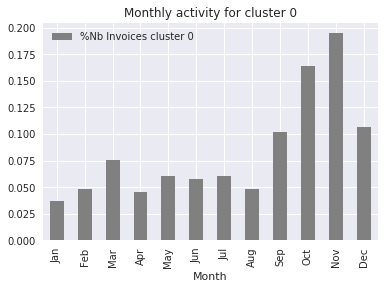

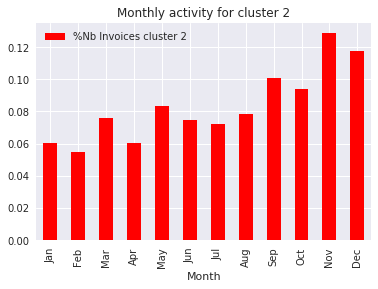

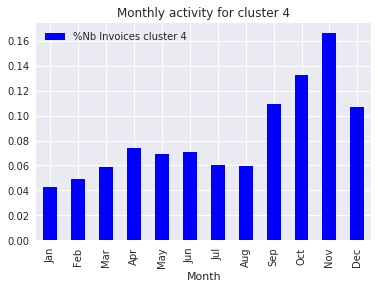

In [166]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

#z_ = plt.figure(figsize=(10,10))
#axes = plt.gca()

feature = 'Month'
list_color=['grey','red','blue']
cluster = 3
i_color = 0
for cluster in list_cluster:
    df = df_invoice_line[df_invoice_line.cluster==cluster].groupby([feature]).agg({'InvoiceNo': lambda x:len(x)})
    df = df.apply(lambda x: x/sum(x))
    df.rename(columns={'InvoiceNo':'%Nb Invoices cluster '+str(cluster)}, inplace=True)
    df.rename(dict_month_name,axis='index', inplace=True)

    axes.set_xlabel('Months')
    axes.yaxis.set_major_formatter(mtick.PercentFormatter())

    #df.plot(kind='bar', ax=axes, color=list_color[i_color], title='Monthly activity for cluster '+str(cluster))
    df.plot(kind='bar', color=list_color[i_color], title='Monthly activity for cluster '+str(cluster))
    i_color += 1

In [167]:
df_ = df_invoice_line.groupby(['cluster','Month']).agg({'Month': lambda x:len(x)})
df_.rename(columns={'Month':'MonthActivity'}, inplace=True)
df_.reset_index(inplace=True)
df_.sample()

,cluster,Month,MonthActivity
23,2,12,10166


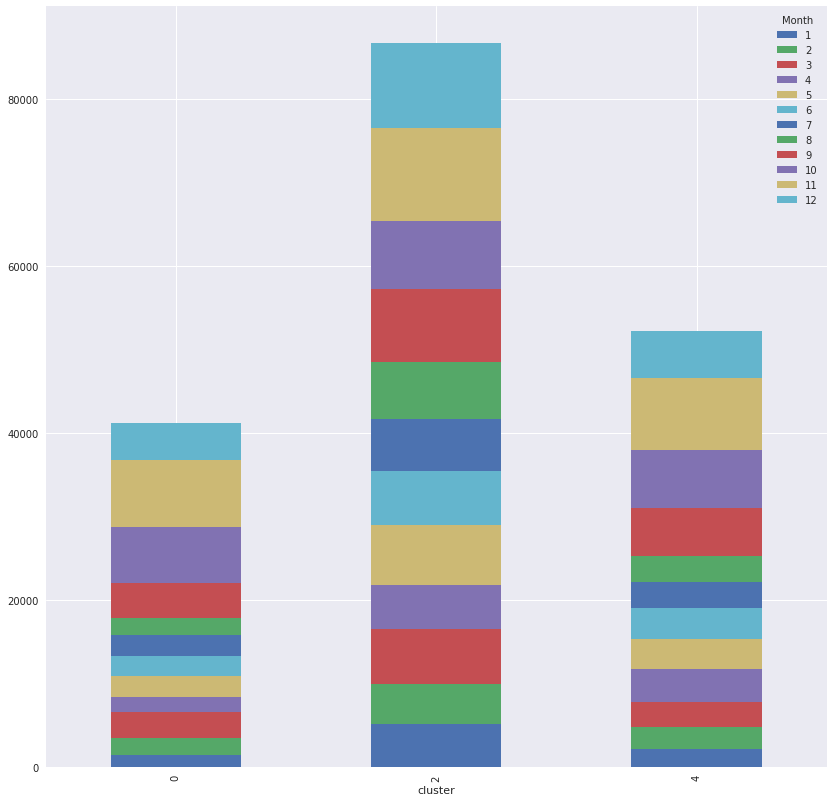

In [168]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,14))
ax = plt.gca()

df_invoice_line.groupby(['cluster','Month'])['Month'].size().unstack().plot(kind='bar',stacked=True, ax=ax)

In [169]:
dict_month_name

{1: 'Jan',
 2: 'Feb',
 3: 'Mar',
 4: 'Apr',
 5: 'May',
 6: 'Jun',
 7: 'Jul',
 8: 'Aug',
 9: 'Sep',
 10: 'Oct',
 11: 'Nov',
 12: 'Dec'}

    cluster  Month  MonthActivity
27        4      4           3888


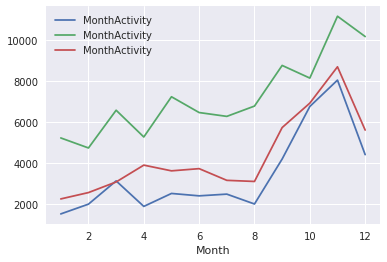

In [170]:
import matplotlib.pyplot as plt
import pandas as pd

df_ = df_invoice_line.groupby(['cluster','Month']).agg({'Month': lambda x:len(x)})
df_.rename(columns={'Month':'MonthActivity'}, inplace=True)
df_.reset_index(inplace=True)
df_.sample()

df_.rename(columns=dict_month_name, inplace=True)

print(df_.sample())
# gca stands for 'get current axis'
ax = plt.gca()
for cluster in list_cluster:
    df_.rename(dict_month_name,axis='index', inplace=True)
    df_[df_.cluster==cluster].plot(kind='line',x='Month',y='MonthActivity',ax=ax)



plt.show()

In [171]:
df_.sample()

,cluster,Month,MonthActivity
May,0,6,2388


(72, 4)


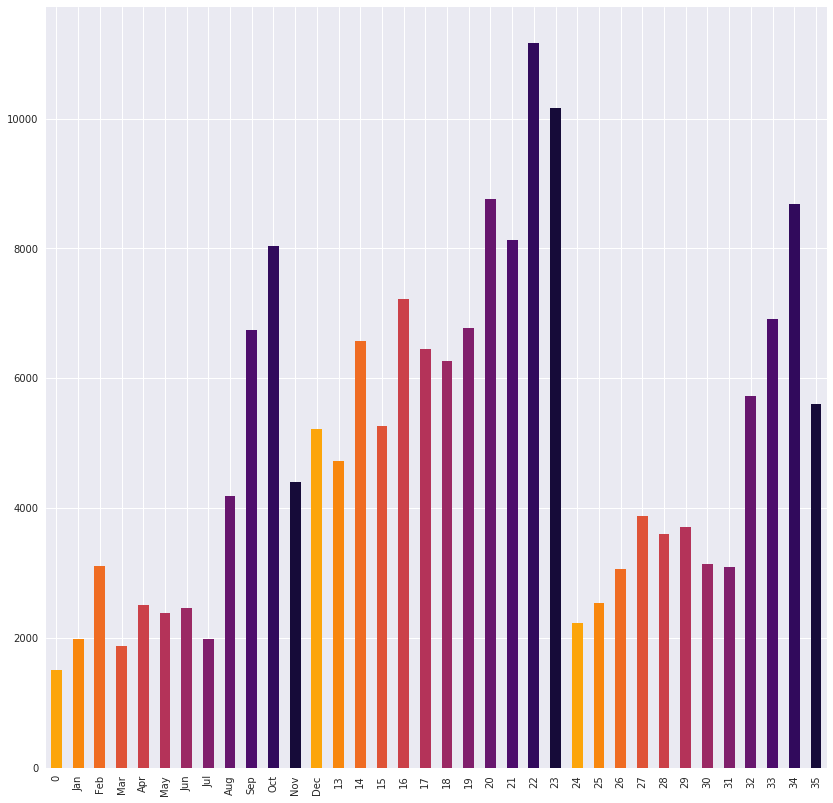

In [172]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import cm

color = cm.inferno_r(np.linspace(.2,.9, 12))
color = np.vstack((color[:12],color[:12]))
color = np.vstack((color[:24],color[:24]))
color = np.vstack((color[:48],color[:24]))

print(color.shape)
plt.figure(figsize=(14,14))


df_.query("cluster==0 or cluster==2 or cluster==4")['MonthActivity'].plot(kind='bar',  color=color)
plt.show()

### POD activity by cluster

#### POD activity distribution

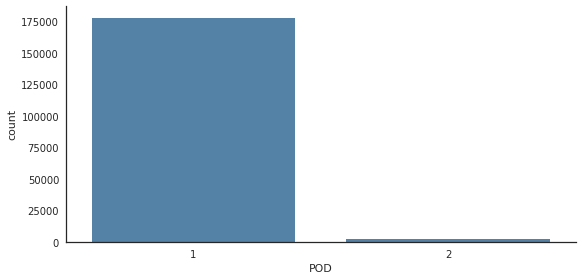

In [173]:
import seaborn as sns

with sns.axes_style('white'):
    g = sns.factorplot("POD", data=df_invoice_line, aspect=2, kind="count", color='steelblue')

#### POD=1 activity dispersion per cluster

        Cluster 0  Cluster 2  Cluster 4
median       22.0      213.0       77.0


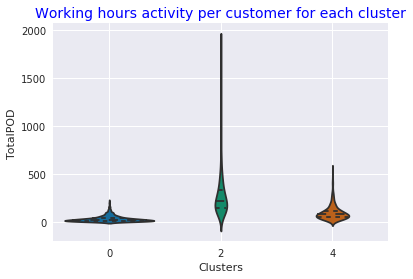

In [174]:
import p5_util_plot
#----------------------------------------------------------------------------------
# Restrict dataframe to POD activity value 1 (in working hours)
#----------------------------------------------------------------------------------
df_pod_customers = df_invoice_line[df_invoice_line.POD==1]

feature = 'POD'
new_feature = 'TotalPOD'
lambda_func = lambda x:len(x)
plot_cond = ''
y_label = None
title = "Working hours activity per customer for each cluster"

p5_util_plot.df_plot_feature_cluster(df_pod_customers, df_customers, feature,new_feature, list_cluster\
, lambda_func, plot_cond, y_label, title)

#### POD=2 activity dispersion per cluster

        Cluster 0  Cluster 2  Cluster 4
median       15.0       18.0       26.0


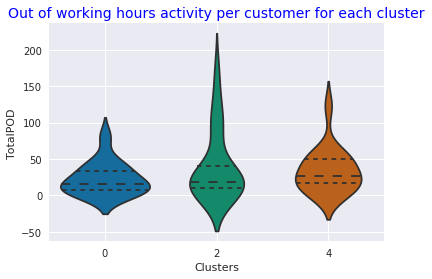

In [175]:
import p5_util_plot
#----------------------------------------------------------------------------------
# Restrict dataframe to POD activity value 2 (out of working hours)
#----------------------------------------------------------------------------------
df_pod_customers = df_invoice_line[df_invoice_line.POD==2]

feature = 'POD'
new_feature = 'TotalPOD'
lambda_func = lambda x:len(x)
plot_cond = ''
y_label = None
title = "Out of working hours activity per customer for each cluster"

p5_util_plot.df_plot_feature_cluster(df_pod_customers, df_customers, feature,new_feature, list_cluster\
, lambda_func, plot_cond, y_label, title)

Behaviours considering POD activity are similar from one cluster to another.

### Monthly incomes by cluster

Data sample and dataframe customer model are reloaded.

In [176]:
import p5_util
is_reloaded = True
if is_reloaded is True:
    df_invoice_line = p5_util.p5_reload_data_sample()
    print(df_invoice_line.shape)  

import p5_util
if is_reloaded is True:
    fileName = './data/df_customers_cluster.dump'
    df_customers = p5_util.object_load(fileName)
    print(df_customers.shape)

p5_util.object_load : fileName= ./data/df_invoice_line_sample_random.dump
(194907, 7)
(194907, 7)
p5_util.object_load : fileName= ./data/df_customers_cluster.dump
(2124, 340)


Build dataframe ``df_monthy_incomes``

In [177]:
df_monthly_incomes = p5_util.df_monthly_incomes_build(df_invoice_line, df_customers, dict_month_name)

``cluster`` column is added to monthy incomes

In [178]:
df_monthly_incomes = p5_util.df_add_cluster(df_monthly_incomes, df_customers.cluster)

In [179]:
if 'CustomerID' in df_customers.columns:
    df_customers.index = df_customers.CustomerID
    del(df_customers['CustomerID'])

#### Display effective for each cluster

In [180]:
# Effective per cluser
df = df_monthly_incomes.groupby('cluster').agg({'cluster':lambda x:len(x)})
df['Effective'] = df.cluster
del(df['cluster'])
print(df)

         Effective
cluster           
0             1283
1                1
2              303
3                1
4              535
5                1


### Incomes

#### Plot of monthly incomes considering clusters

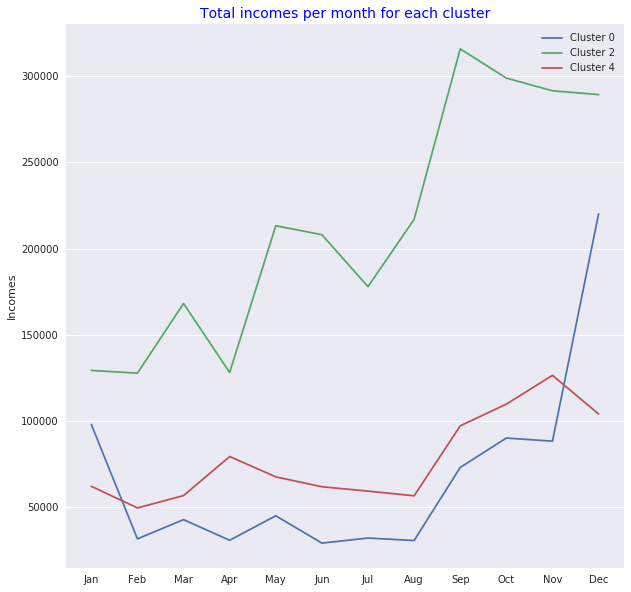

In [181]:
import p5_util_plot
p5_util_plot.df_monthly_incomes_plot(df_monthly_incomes, dict_month_name, list_cluster)

Monthly incomes shows differences between clusters : 

* Cluster 0 generates the less incomes
* Cluster 2 generates most incomes
* Cluster 4 show incomes between cluster 0 and 2

#### Plot monthly incomes dispersion for each cluster

In [182]:
if 'CustomerID' not in df_customers.columns:
    df_customers['CustomerID'] = df_customers.index

**Plot distribution of incomes per customer for each cluster.**

Dataframe ``df_incomes_cluster`` is  a table containing total incomes for each of the customers. 

Each customer is assigned a cluster.

        Cluster 0  Cluster 2  Cluster 4
median     336.96    3820.27    1335.19


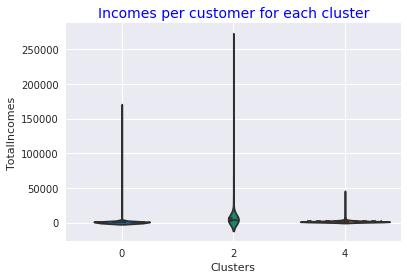

In [183]:
import p5_util_plot

df_incomes_cluster = df_invoice_line.groupby(['CustomerID']).agg({'Total': lambda x:sum(x)})
df_incomes_cluster.rename(columns={'Total':'Incomes'}, inplace=True)
df_incomes_cluster.reset_index(inplace=True)


feature = 'Incomes'
new_feature = 'TotalIncomes'
lambda_func = lambda x:sum(x)
plot_cond = ''
y_label = None
title = "Incomes per customer for each cluster"

p5_util_plot.df_plot_feature_cluster(df_incomes_cluster, df_customers, feature,new_feature, list_cluster\
, lambda_func, plot_cond, y_label, title)

        Cluster 0  Cluster 2  Cluster 4
median     336.96    3820.27    1335.19


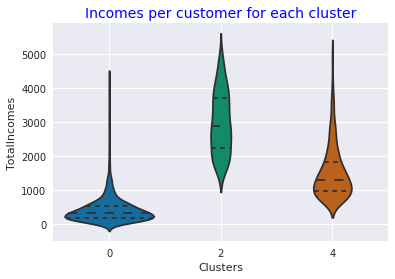

In [184]:
plot_cond = 'TotalIncomes<=5000'
p5_util_plot.df_plot_feature_cluster(df_incomes_cluster, df_customers, feature,new_feature, list_cluster\
, lambda_func, plot_cond, y_label, title)

**Creates generic dataframe ``df_cluster`` from ``df_invoice_line``.**

``df_invoice_line`` dataframe is the sampled dataset.

``df_cluster`` dataframe is issued from ``df_invoice_line`` dataframe. It compounds information over numbers of invoices and number of invoices lines per invoice.

``df_cluster`` is used to plot distributions of invoices per customer and invoice lines per customer, such, for each cluster.


In [185]:
import p3_util_plot

df_cluster = df_invoice_line.groupby(['CustomerID','InvoiceNo']).agg({'InvoiceNo': lambda x:len(x)})
df_cluster.rename(columns={'InvoiceNo':'InvoiceLineCount'}, inplace=True)
df_cluster.reset_index(inplace=True)

**Plot distribution of invoices count per customer for each cluster.**

        Cluster 0  Cluster 2  Cluster 4
median        1.0       11.0        4.0


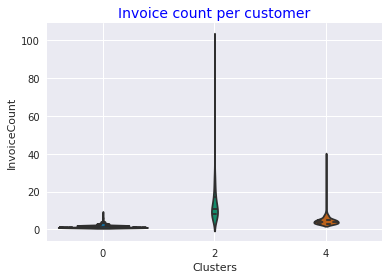

In [186]:
import p5_util_plot

feature = 'InvoiceNo'
new_feature = 'InvoiceCount'
lambda_func = lambda x:len(x)
plot_cond = ''
title = "Invoice count per customer"
y_label = None

#df_feature_cluster = df.groupby(['CustomerID']).agg({feature: lambda_func})
if True:
    p5_util_plot.df_plot_feature_cluster(df_cluster, df_customers, feature,new_feature, list_cluster\
    , lambda_func, plot_cond, y_label, title)

        Cluster 0  Cluster 2  Cluster 4
median        1.0       11.0        4.0


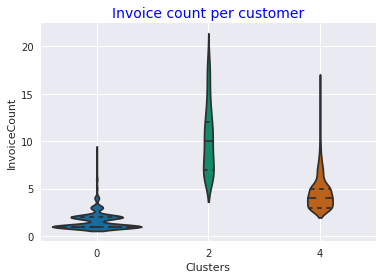

In [187]:
plot_cond = 'InvoiceCount<20'
p5_util_plot.df_plot_feature_cluster(df_cluster, df_customers, feature,new_feature, list_cluster\
, lambda_func, plot_cond, y_label, title)

**Plot distribution of invoice lines count per customer for each cluster.**

        Cluster 0  Cluster 2  Cluster 4
median       22.0      213.0       78.0


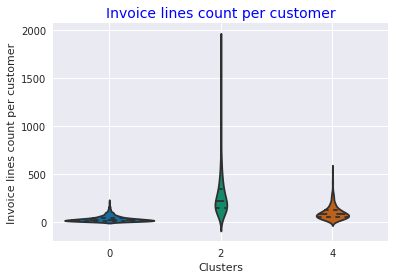

In [188]:
import p5_util_plot

feature = 'InvoiceLineCount'
new_feature = 'InvoiceLineCount'
lambda_func = lambda x:sum(x)
plot_cond = ''
y_label = "Invoice lines count per customer"
title = y_label

p5_util_plot.df_plot_feature_cluster(df_cluster, df_customers, feature,new_feature, list_cluster\
, lambda_func, plot_cond, y_label, title)

        Cluster 0  Cluster 2  Cluster 4
median       22.0      213.0       78.0


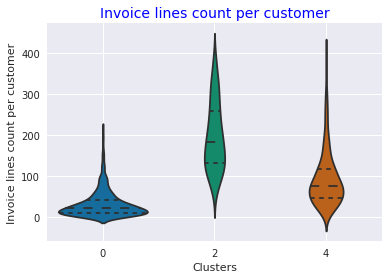

In [189]:
plot_cond = 'InvoiceLineCount<400'
p5_util_plot.df_plot_feature_cluster(df_cluster, df_customers, feature,new_feature, list_cluster\
, lambda_func, plot_cond, y_label, title)

**Plot distribution of quantities of items per customer for each cluster.**

        Cluster 0  Cluster 2  Cluster 4
median      191.0     2273.0      784.0


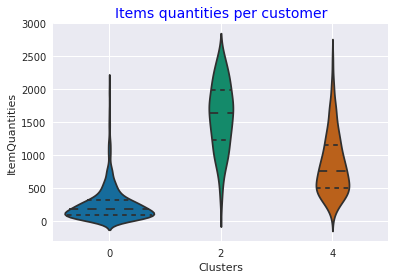

In [190]:
import p5_util_plot

feature = 'Quantity'
new_feature = 'ItemQuantities'
lambda_func = lambda x:sum(x)
plot_cond = 'ItemQuantities<2500'
title = "Items quantities per customer"
y_label = None

p5_util_plot.df_plot_feature_cluster(df_invoice_line, df_customers, feature,new_feature, list_cluster\
, lambda_func, plot_cond, y_label, title)

        Cluster 0  Cluster 2  Cluster 4
median      191.0     2273.0      784.0


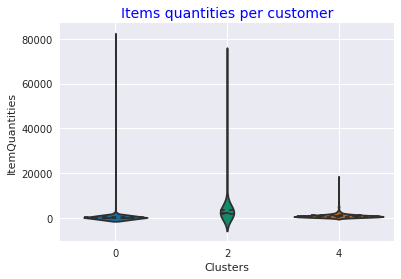

In [191]:
plot_cond = ''
p5_util_plot.df_plot_feature_cluster(df_invoice_line, df_customers, feature,new_feature, list_cluster\
, lambda_func, plot_cond, y_label, title)

**Plot distribution of mean of items unit price per customer for each cluster**.

        Cluster 0  Cluster 2  Cluster 4
median      2.868   2.771783   2.853529


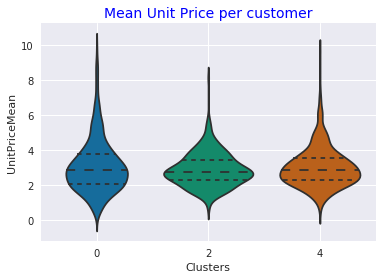

In [192]:
import p5_util_plot
feature = 'UnitPrice'
new_feature = 'UnitPriceMean'
lambda_func = lambda x:sum(x)/len(x)
plot_cond = 'UnitPriceMean<10'
title = "Mean Unit Price per customer"
y_label = None
p5_util_plot.df_plot_feature_cluster(df_invoice_line, df_customers, feature,new_feature, list_cluster\
, lambda_func, plot_cond, y_label, title)

#### Total incomes per customer considering clusters

Sub-total is computed per line of invoice.

[0 2 4]


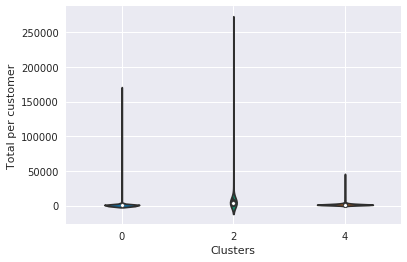

In [193]:
import seaborn as sns
import pandas as pd

import p5_util

df_invoice_line['SubTotal'] = df_invoice_line['UnitPrice'] * df_invoice_line['Quantity']

#----------------------------------------------------------------------------
# Total incomes per customer is computed grouping customers and making sum 
# of SubTotal column.
#----------------------------------------------------------------------------
df_total_cluster = df_invoice_line.groupby(['CustomerID']).agg({'SubTotal': lambda x:sum(x)})

df_total_cluster.rename(columns={'SubTotal':'Total'}, inplace=True)
df_total_cluster.reset_index(inplace=True)


df_total_cluster = p5_util.df_cluster_list_add(df_total_cluster, df_customers, list_cluster)
print(df_total_cluster.cluster.unique())


axes = sns.violinplot(y='Total', x='cluster', 
                 data=df_total_cluster, 
                 width=0.5,
                 palette="colorblind")
axes.set_xlabel('Clusters')
axes.set_ylabel('Total per customer')
plt.grid(True)

#### Differentiation over StockCode

In [194]:
import pandas as pd

df_invoice_line.StockCode.unique().shape
if 'CustomerID' not in df_invoice_line.columns:
    df_customers.reset_index(inplace=True)

if 'cluster' not in  df_invoice_line.columns:   
    df_invoice_line = pd.merge(df_invoice_line, df_customers[['CustomerID','cluster']], on='CustomerID')

df_invoice_line.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Total', 'Month', 'SubTotal', 'cluster'],
      dtype='object')

In [195]:
import p3_util_plot
print(list_cluster)
for cluster in list_cluster:
    p3_util_plot.printmd("Stock code count for cluster "+str(cluster)+" = "+str(  df_invoice_line.query("cluster=="+str(cluster) ).StockCode.unique().shape[0]))

p3_util_plot.printmd("Stock code count for whole sampling : "+str(df_invoice_line.StockCode.unique().shape[0]))
    

[0, 2, 4]


<p><font color='green'>**Stock code count for cluster 0 = 3151**</font></p>

<p><font color='green'>**Stock code count for cluster 2 = 3179**</font></p>

<p><font color='green'>**Stock code count for cluster 4 = 3031**</font></p>

<p><font color='green'>**Stock code count for whole sampling : 3507**</font></p>

### <font color='blue'> RFM distribution from inside clusters </font>

#### Loading RFM dataframe per customer

In [196]:
import pandas as pd
import p5_util

fileName = './data/df_RFM.dump'
df_RFM = p5_util.object_load(fileName)

#print(df_RFM.shape)
df_RFM.index = df_RFM.CustomerID
del(df_RFM['CustomerID'])
#print(df_RFM.sample(1))

fileName = './data/df_customers.dump'
df_customers = p5_util.object_load(fileName)

df_customers = p5_util.df_add_cluster(df_customers, pred_gmm)

df_RFM = pd.concat([df_RFM,df_customers['cluster']],axis=1, join='inner')



p5_util.object_load : fileName= ./data/df_RFM.dump
p5_util.object_load : fileName= ./data/df_customers.dump


#### Build arrays of indexes for each cluster

In [197]:
dict_cluster_index = dict()
for i_cluster in range(0,n_cluster,1):
    dict_cluster_index[i_cluster] = df_RFM[df_RFM.cluster==i_cluster].index

#### Plot RFM distributions per cluster

In [198]:
df_RFM.columns, df_customers.shape

(Index(['Frequency', 'Recency', 'Monatary', 'neg_recency', 'R_score', 'F_score',
        'M_score', 'RFM', 'cluster'],
       dtype='object'), (2124, 340))

In [199]:
df_RFM.columns

Index(['Frequency', 'Recency', 'Monatary', 'neg_recency', 'R_score', 'F_score',
       'M_score', 'RFM', 'cluster'],
      dtype='object')

In [200]:
list_cluster
#n_cluster

[0, 2, 4]

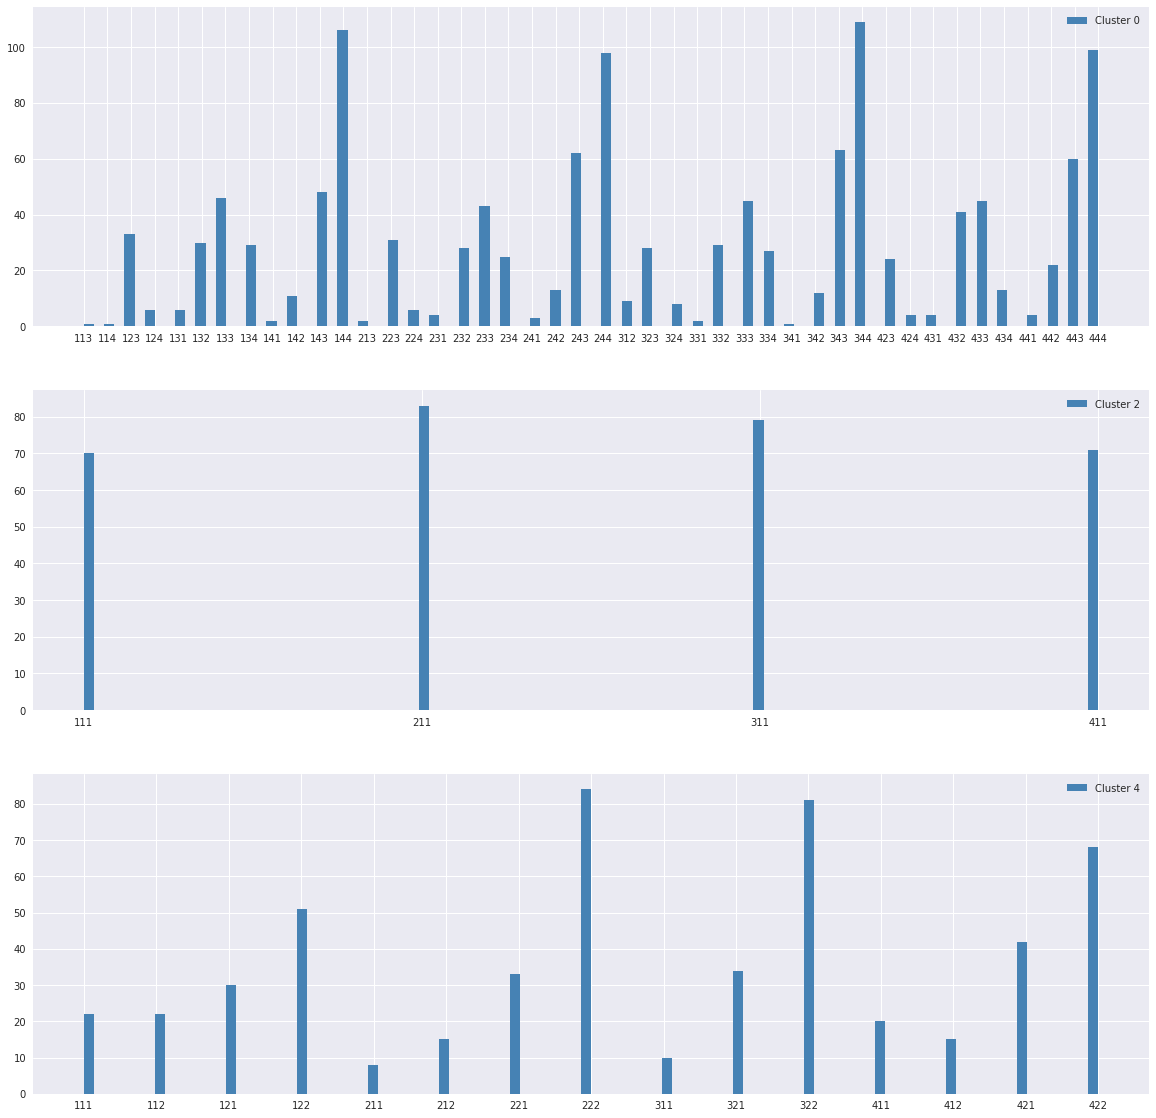

In [201]:
plt.figure(figsize=(20,20))  # create a plot figure

dict_df = dict()
ylabel = 'Frequence'
xlabel = "RFM categories"
i_panel = 1
for cluster, arr_cluster_index in dict_cluster_index.items():
    if cluster in list_cluster:
        title = "Cluster "+str(cluster)+" : RFM"
        df = df_RFM.loc[arr_cluster_index,:]
        plt.subplot(3, 1, i_panel) # (rows, columns, panel number)
        i_panel += 1
        plt.hist(df.RFM, color='steelblue', histtype='stepfilled', label='Cluster '+str(cluster), bins=100)
        plt.legend()
    #p3_util_plot.ser_hist(df.RFM,title,xlabel, ylabel,param_bins=100, param_font_size=12, \
    #         param_rotation=90,figsize=(10,10))


# <font color='blues'>Ploting data points</font>

## <font color='blue'>Dimension shift with linear PCA</font>

In [202]:
import p5_util
is_reloaded = True
if is_reloaded is True:
    fileName = './data/df_customers_cluster.dump'
    df_customers = p5_util.object_load(fileName)
    print(df_customers.shape)

p5_util.object_load : fileName= ./data/df_customers_cluster.dump
(2124, 340)


In [203]:
df_customers.columns

Index(['cluster', 'w_rfm_0', 'w_rfm_1', 'w_rfm_2', 'w_rfm_3', 'w_rfm_4',
       'w_rfm_5', 'w_rfm_6', 'w_rfm_7', 'w_rfm_8',
       ...
       'nlp_pca_240', 'nlp_pca_241', 'nlp_pca_242', 'nlp_pca_243',
       'nlp_pca_244', 'nlp_pca_245', 'nlp_pca_246', 'nlp_pca_247',
       'nlp_pca_248', 'nlp_pca_249'],
      dtype='object', length=340)

In [204]:
import p5_util
list_col = [col for col in df_customers.columns if col not in ['cluster']]
df_customers = p5_util.df_cluster_filter(df_customers, list_cluster)

** Component = 100
** Component = 200
** Component = 300


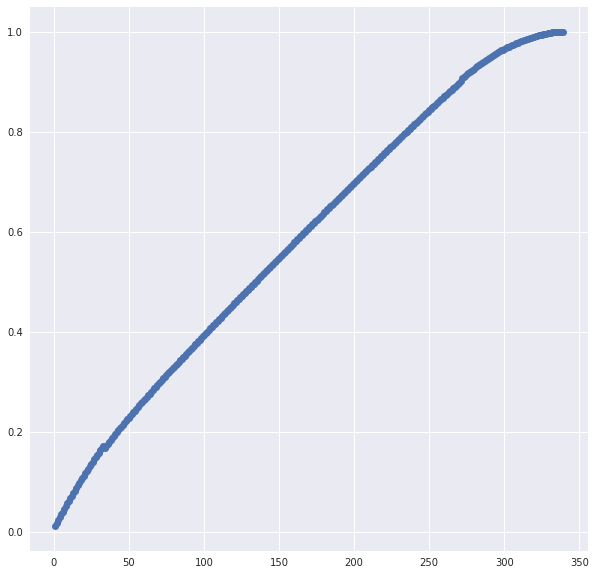

In [205]:
import p3_util_plot
is_pca_plot = True
if is_pca_plot is True:
    z__ = p3_util_plot.df_pca_all_plot(df_customers[list_col], plot=True)

In [206]:
import p5_util

print(df_customers[list_col].shape)
n_dim = 2
root_name = 'pca_'
df_customers_pca, pca = p5_util.df_pca_reduce(df_customers[list_col]\
                                            , n_dim, root_name, p_is_scale=False)
print(df_customers_pca.shape)


(2121, 339)
(2121, 2)


In [207]:

#len(list_cluster)

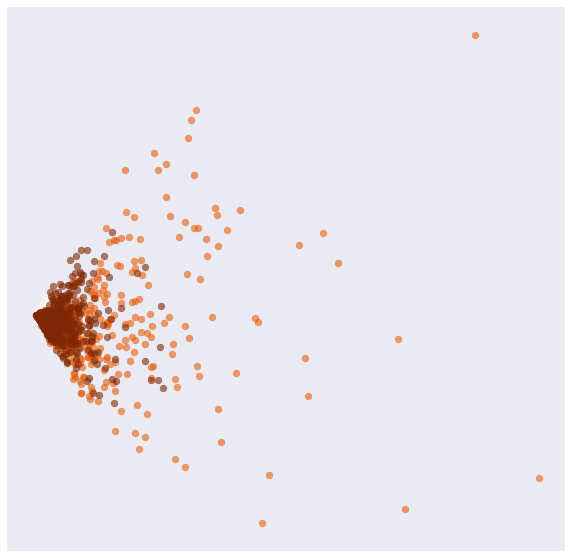

In [208]:
import p3_util_plot
cluster_labels = df_customers.cluster.values

nclusters = len(df_customers.cluster.unique())
title = "Reduced with PCA"
X_plot  = df_customers_pca.values
p3_util_plot.clustering_plot(X_plot, cluster_labels, nclusters, title=None, X_center=None)

## <font color='blue'>Dimension shift with t-SNE</font>

tSNE allows to build separate groups of data points based on probability points of same group 
belongs to same neighborhood.

This is also an easy way to apply clustering based on this dimension reduction.

In [209]:
import p5_util
is_reloaded = True
if is_reloaded is True:
    fileName = './data/df_customers_cluster.dump'
    df_customers = p5_util.object_load(fileName)
    print(df_customers.shape)

p5_util.object_load : fileName= ./data/df_customers_cluster.dump
(2124, 340)


Only points with cluster value in ``list_cluster`` are extracted from ``df_customers``

In [210]:
df_customers = p5_util.df_customers_cluster_filter(df_customers, list_cluster)

(2124, 340)
(2121, 340)


Data values are extracted from clusterised dataframe.

In [211]:
list_col_keep = [col for col in df_customers.columns if col not in ['cluster']]
df_customers[list_col_keep].columns
X_std = df_customers[list_col_keep].values

T-SNE is applied for a range of perplexities values.

In [212]:
import p5_util
my_list_tsne_perplexity=[var for var in range(5,55,5)]
dict_tsne_result = p5_util.tsne_2D_process_perplexity(X_std, tsne_iter=1000, list_tsne_perplexity=my_list_tsne_perplexity)

tSNE perplexity : 5/50 ...
tSNE perplexity : 10/50 ...
tSNE perplexity : 15/50 ...
tSNE perplexity : 20/50 ...
tSNE perplexity : 25/50 ...
tSNE perplexity : 30/50 ...
tSNE perplexity : 35/50 ...
tSNE perplexity : 40/50 ...
tSNE perplexity : 45/50 ...
tSNE perplexity : 50/50 ...


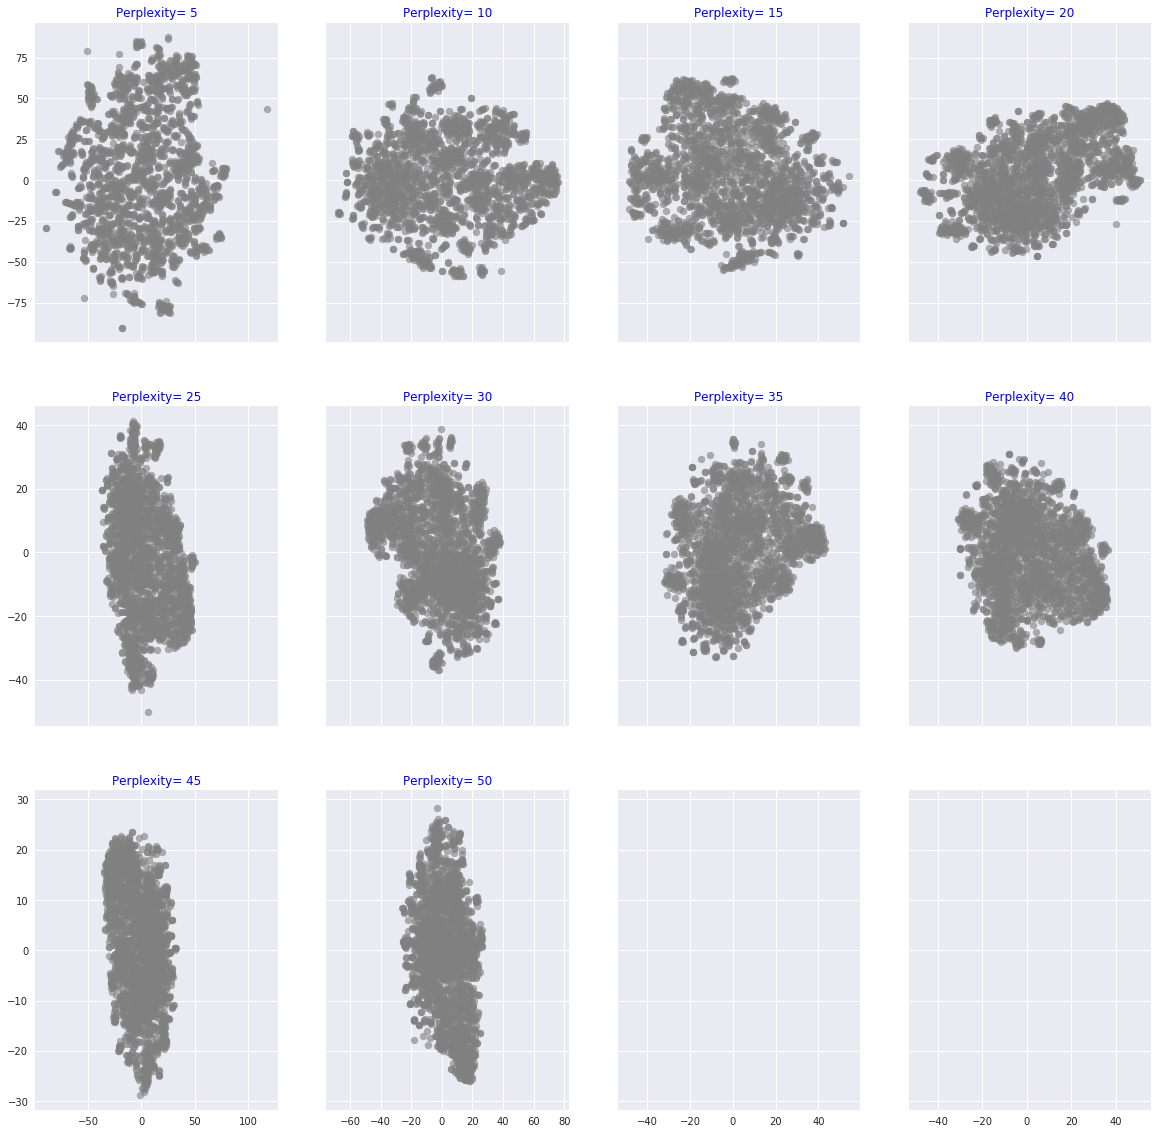

In [213]:
import p5_util_plot
nb_col = 4     
p5_util_plot.plot_2D_dict_tsne_result(dict_tsne_result, nb_col)

In [214]:
df_customers.cluster.unique()

array([0, 2, 4], dtype=int64)

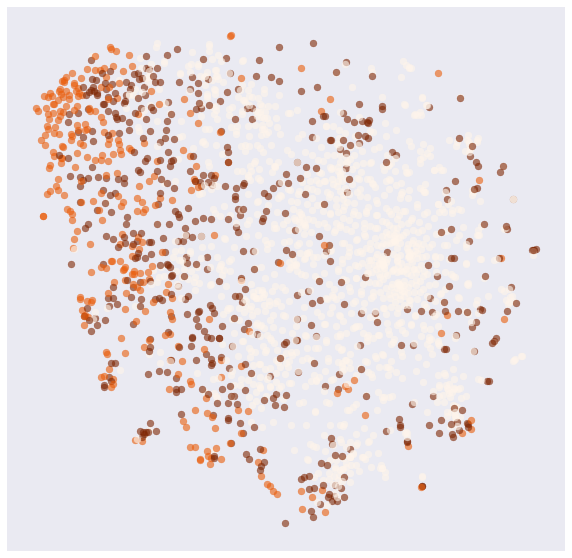

In [215]:
import p3_util_plot
#def this_clustering_plot():
cluster_labels = df_customers.cluster.values
nclusters = len(list_cluster)
best_perplexity = 45
title = "Perplexity = "+str(best_perplexity)
X_plot  = dict_tsne_result[best_perplexity]
p3_util_plot.clustering_plot(X_plot, cluster_labels, nclusters, title=None, X_center=None)

#### A sample of data values are extracted from clusterised dataframe.

In [219]:
sample_ratio = int(df_customers[list_col_keep].shape[0]*0.2)
sample_ratio
df_customers_sample = df_customers[list_col_keep].sample(sample_ratio)
X_std = df_customers_sample.values

T-SNE is applied for a range of perplexities values.

In [227]:
import p5_util
my_list_tsne_perplexity=[var for var in range(5,55,5)]
dict_tsne_result = p5_util.tsne_2D_process_perplexity(X_std, tsne_iter=3000, list_tsne_perplexity=my_list_tsne_perplexity)

tSNE perplexity : 5/50 ...
tSNE perplexity : 10/50 ...
tSNE perplexity : 15/50 ...
tSNE perplexity : 20/50 ...
tSNE perplexity : 25/50 ...
tSNE perplexity : 30/50 ...
tSNE perplexity : 35/50 ...
tSNE perplexity : 40/50 ...
tSNE perplexity : 45/50 ...
tSNE perplexity : 50/50 ...


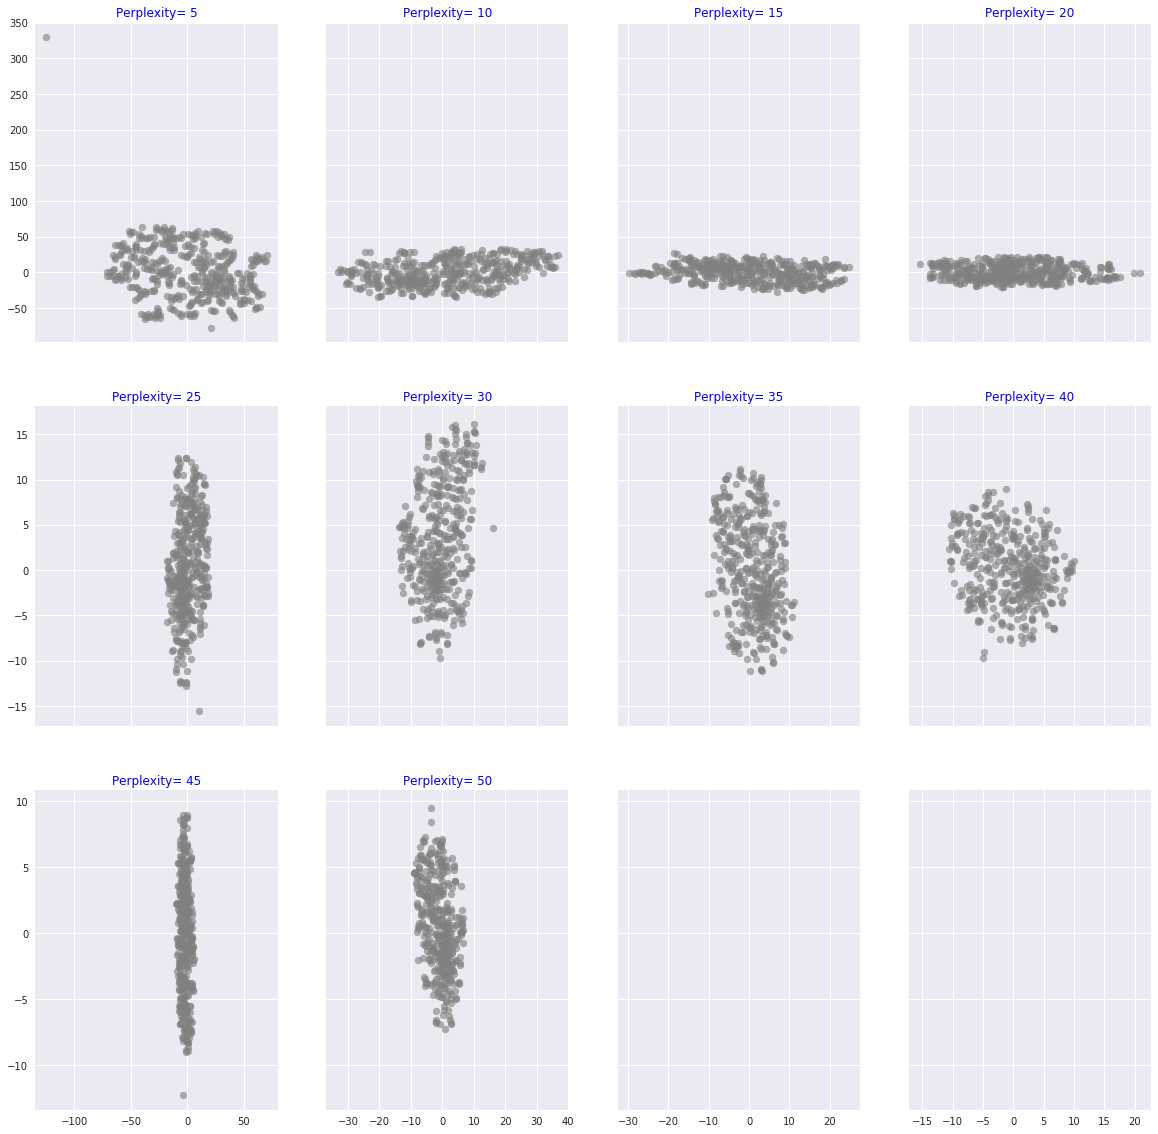

In [228]:
import p5_util_plot
nb_col = 4     
p5_util_plot.plot_2D_dict_tsne_result(dict_tsne_result, nb_col)

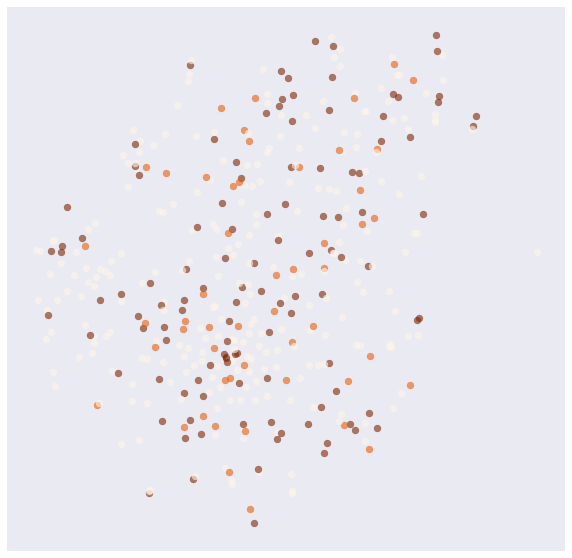

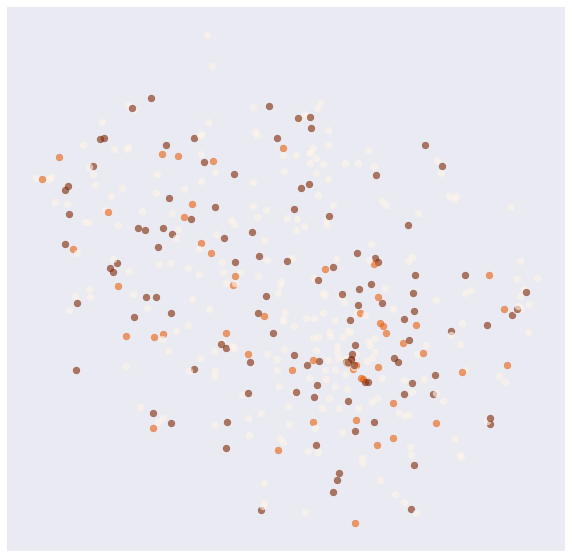

In [229]:
import p3_util_plot
#def this_clustering_plot():
cluster_labels = df_customers.cluster.values
nclusters = len(list_cluster)
best_perplexity = 30
title = "Perplexity = "+str(best_perplexity)
X_plot  = dict_tsne_result[best_perplexity]
p3_util_plot.clustering_plot(X_plot, cluster_labels, nclusters, title=None, X_center=None)

best_perplexity = 50
title = "Perplexity = "+str(best_perplexity)
X_plot  = dict_tsne_result[best_perplexity]
p3_util_plot.clustering_plot(X_plot, cluster_labels, nclusters, title=None, X_center=None)